In [2]:
from cartopy import crs as ccrs
import cartopy.feature as cfeature
import multiprocessing
import sys
import cartopy.feature as cfeature
import cmaps
import matplotlib.pyplot as plt
import numpy as np
import tqdm as tq
import xarray as xr
from cartopy.io.shapereader import Reader
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter  # 专门提供经纬度的
from cartopy.util import add_cyclic_point
from matplotlib import gridspec
from matplotlib import ticker
from matplotlib.pyplot import quiverkey
from matplotlib.ticker import MultipleLocator
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from scipy.ndimage import filters
from climkit.significance_test import corr_test
from climkit.TN_WaveActivityFlux import TN_WAF_3D
from climkit.Cquiver import *
from climkit.data_read import *
from climkit.lonlat_transform import transform as lonlat_trs

def regress(time_series, data):
    # 将 data 重塑为二维：时间轴为第一个维度
    reshaped_data = data.reshape(len(time_series), -1)

    # 减去均值以中心化（标准化自变量和因变量）
    time_series_mean = time_series - np.mean(time_series)
    data_mean = reshaped_data - np.mean(reshaped_data, axis=0)

    # 计算分子（协方差的分子）
    numerator = np.sum(data_mean * time_series_mean[:, np.newaxis], axis=0)

    # 计算分母（自变量的平方和）
    denominator = np.sum(time_series_mean ** 2)

    # 计算回归系数
    regression_coef = numerator / denominator
    correlation = numerator / (np.sqrt(np.sum(data_mean ** 2, axis=0)) * np.sqrt(np.sum(time_series_mean ** 2)))
    # 重塑为 (lat, lon)
    regression_map = regression_coef.reshape(data.shape[1:])
    correlation_map = correlation.reshape(data.shape[1:])
    return regression_map, correlation_map

def partial_regress(independent_var, dependent_data, control_var):
    """
    计算偏回归和偏相关系数。

    这个函数计算自变量(X)和因变量(Y)之间的关系，同时控制第三个变量(Z)的影响。
    方法是计算X对Z回归的残差和Y对Z回归的残差，然后计算这两个残差序列之间的回归和相关。

    参数:
    independent_var (array-like): 自变量 X，一个一维的时间序列 (shape: [time])。
    dependent_data (array-like): 因变量 Y，一个多维数组，第一个维度必须是时间 (shape: [time, lat, lon, ...])。
    control_var (array-like): 需要控制的变量 Z，一个一维的时间序列 (shape: [time])。

    返回:
    tuple: (partial_regression_map, partial_correlation_map)
        - partial_regression_map (numpy.ndarray): 偏回归系数图，形状与 dependent_data 的空间维度相同。
        - partial_correlation_map (numpy.ndarray): 偏相关系数图，形状与 dependent_data 的空间维度相同。
    """
    # 确保输入是numpy数组
    x = np.asarray(independent_var)
    y = np.asarray(dependent_data)
    z = np.asarray(control_var)

    # 检查时间维度是否匹配
    if x.shape[0] != y.shape[0] or x.shape[0] != z.shape[0]:
        raise ValueError("所有输入的时间维度长度必须一致。")

    # 将 Y 重塑为二维：(时间, 空间点)
    original_y_shape = y.shape
    reshaped_y = y.reshape(original_y_shape[0], -1)

    # --- 核心步骤：残差法 ---

    # 1. 中心化所有变量 (减去均值)
    x_mean = x - np.mean(x)
    z_mean = z - np.mean(z)
    y_mean = reshaped_y - np.mean(reshaped_y, axis=0)

    # 2. 计算残差
    # 2a. 回归 X on Z，计算 X 的残差 (res_x)
    #    回归系数 beta_xz = Cov(X, Z) / Var(Z)
    beta_xz = np.sum(x_mean * z_mean) / np.sum(z_mean ** 2)
    res_x = x_mean - beta_xz * z_mean

    # 2b. 对每个空间点，回归 Y on Z，计算 Y 的残差 (res_y)
    #    回归系数 beta_yz = Cov(Y, Z) / Var(Z)
    #    利用 numpy 的广播机制进行高效计算
    beta_yz = np.sum(y_mean * z_mean[:, np.newaxis], axis=0) / np.sum(z_mean ** 2)
    res_y = y_mean - beta_yz * z_mean[:, np.newaxis]

    # 3. 在残差上进行简单的线性回归和相关分析
    #    这部分与您原始代码的逻辑相同，只是操作对象从原始数据变为残差

    # 计算分子 (协方差的分子)
    numerator = np.sum(res_y * res_x[:, np.newaxis], axis=0)

    # 计算分母 (自变量残差的平方和)
    denominator_reg = np.sum(res_x ** 2)

    # 防止除以零：如果res_x的方差为0，说明X完全由Z解释，偏相关/回归无意义
    if denominator_reg == 0:
        nan_array = np.full(reshaped_y.shape[1], np.nan)
        partial_regression_coef = nan_array
        partial_correlation = nan_array
    else:
        # 计算偏回归系数
        partial_regression_coef = numerator / denominator_reg

        # 计算偏相关系数
        denominator_corr_term1 = np.sqrt(np.sum(res_y ** 2, axis=0))
        denominator_corr_term2 = np.sqrt(denominator_reg) # denominator_reg is already sum(res_x**2)
        denominator_corr = denominator_corr_term1 * denominator_corr_term2

        # 创建一个用NaN填充的数组，以安全地处理除以零的情况
        partial_correlation = np.full_like(numerator, np.nan)
        # 找到分母不为零的有效位置
        valid_mask = denominator_corr != 0
        # 仅在有效位置进行计算
        partial_correlation[valid_mask] = numerator[valid_mask] / denominator_corr[valid_mask]

    # 4. 将结果重塑回原始空间维度
    partial_regression_map = partial_regression_coef.reshape(original_y_shape[1:])
    partial_correlation_map = partial_correlation.reshape(original_y_shape[1:])

    return partial_regression_map, partial_correlation_map

def corr(time_series, data):
    # 计算相关系数
    # 将 data 重塑为二维：时间轴为第一个维度
    reshaped_data = data.reshape(len(time_series), -1)

    # 减去均值以标准化
    time_series_mean = time_series - np.mean(time_series)
    data_mean = reshaped_data - np.mean(reshaped_data, axis=0)

    # 计算分子（协方差）
    numerator = np.sum(data_mean * time_series_mean[:, np.newaxis], axis=0)

    # 计算分母（标准差乘积）
    denominator = np.sqrt(np.sum(data_mean ** 2, axis=0)) * np.sqrt(np.sum(time_series_mean ** 2))

    # 相关系数
    correlation = numerator / denominator

    # 重塑为 (lat, lon)
    correlation_map = correlation.reshape(data.shape[1:])
    return correlation_map

def latlon_fmt(ax, xticks1, yticks1, xmajorLocator, xminorLocator, ymajorLocator, yminorLocator):
    if yticks1 is not None: ax.set_yticks(yticks1, crs=ccrs.PlateCarree())
    if xticks1 is not None: ax.set_xticks(xticks1, crs=ccrs.PlateCarree())
    lon_formatter = LongitudeFormatter()
    lat_formatter = LatitudeFormatter()
    ax.yaxis.set_major_formatter(lat_formatter)
    ax.xaxis.set_major_formatter(lon_formatter)
    # ax.yaxis.set_major_locator(ymajorLocator)
    ax.yaxis.set_minor_locator(yminorLocator)
    # ax.xaxis.set_major_locator(xmajorLocator)
    ax.xaxis.set_minor_locator(xminorLocator)
    ax.tick_params(which='major', length=4, width=.5, color='black')
    ax.tick_params(which='minor', length=2, width=.2, color='black')
    ax.tick_params(which='both', bottom=True, top=False, left=True, labelbottom=True, labeltop=False)
    plt.rcParams['ytick.direction'] = 'out'
    ax.tick_params(axis='both', labelsize=7, colors='black')

def rec(ax, point, color='red'):
    x1, x2 = point[:2]
    y1, y2 = point[2:]
    x, y = [x1, x2, x2, x1, x1], [y1, y1, y2, y2, y1]
    ax.plot(x, y, color=color, transform=ccrs.PlateCarree())

import matplotlib.patheffects as path_effects
def plot_text(ax, x, y, title, size, color):
    txt = ax.text(x, y, title,
         transform=ccrs.PlateCarree(),
         ha='center',
         va='center',
         fontsize=size,
         fontweight='bold',
         color=color,
         fontname='Times New Roman',
         zorder=1000)
    # 添加白色边缘线效果
    txt.set_path_effects([
        path_effects.Stroke(linewidth=0.5, foreground='white'),
        path_effects.Normal()
    ])
    return 0

def qt_plot(ax, u, v, lat, lon):
    %matplotlib qt
    plt.ion()
    from matplotlib.widgets import Slider, TextBox
    axx = ax
    fig_main = ax.figure
    uwind = waf_x_
    vwind = waf_y_
    mag_ = np.sqrt(u**2 + v**2)
    # —— 工具函数 ——
    def _to_np(a):
        try:
            return np.asarray(a.values)  # xarray
        except Exception:
            return np.asarray(a)

    def _has_where(a):
        return hasattr(a, "where")

    def _masked_uv(mag_, uwind, vwind, low_pct, high_pct):
        """按百分位 + (uwind >= 0) 掩膜，兼容 xarray/numpy"""
        mag = _to_np(mag_)
        v_low  = np.nanpercentile(mag, low_pct)
        v_high = np.nanpercentile(mag, high_pct)
        if _has_where(uwind) and _has_where(vwind):
            mask = (mag_ > v_low) & (mag_ <= v_high) & (uwind >= 0)
            u_m = uwind.where(mask); v_m = vwind.where(mask)
        else:
            x = _to_np(uwind); y = _to_np(vwind)
            mask = (mag > v_low) & (mag <= v_high) & (x >= 0)
            u_m = np.where(mask, x, np.nan); v_m = np.where(mask, y, np.nan)
        return u_m, v_m

    def _parse_color(s: str):
        """允许 'none' 或 '#RRGGBB'；异常回退 'none'"""
        if not isinstance(s, str): return 'none'
        s = s.strip()
        if s.lower() == 'none': return 'none'
        if len(s) == 7 and s.startswith('#'): return s
        return 'none'

    # —— 三个层的默认参数（与你一致），注意：不再各自存 scale！——
    A = {"low":85.0, "high":89.0, "regrid":8, "face":"#0066ff", "edge":"#cccccc", "width":0.007}
    B = {"low":70.0, "high":85.0, "regrid":14, "face":"#0066ff", "edge":"#cccccc", "width":0.006}
    C = {"low":0.0, "high":70.0, "regrid":18, "face":"#0066ff", "edge":"#cccccc", "width":0.005}

    # —— 全局共用参数（含“共享 scale”）——
    COMMON = {"linewidth":0.45, "alpha":0.8, "pivot":"mid", "zorder":40}
    SHARED  = {"scale":1.3}  # ← 只有这个 scale，三个分档共用
    _proj   = ccrs.PlateCarree(central_longitude=0)

    # —— quiver 句柄 & quiverkey 句柄 ——
    _quivers = [None, None, None]
    _qkey = None

    def _draw_one(idx, cfg):
        """绘制一个分档；使用共享的 SHARED['scale']"""
        if cfg["low"] > cfg["high"]:
            cfg["low"], cfg["high"] = cfg["high"], cfg["low"]
        u_m, v_m = _masked_uv(mag_, uwind, vwind, cfg["low"], cfg["high"])
        old = _quivers[idx]
        if old is not None:
            try: old.remove()
            except Exception: pass
        _quivers[idx] = axx.quiver(
            lon, lat, u_m, v_m,
            scale=SHARED["scale"],
            linewidth=COMMON["linewidth"],
            color=_parse_color(cfg["face"]),
            edgecolors=_parse_color(cfg["edge"]),
            pivot=COMMON["pivot"],
            transform=_proj,
            alpha=COMMON["alpha"],
            width=cfg["width"],
            regrid_shape=int(cfg["regrid"]),
            zorder=COMMON["zorder"]
        )

    def _redraw(_=None):
        """只更新三层 quiver 与 quiverkey，不触碰其它轴"""
        global WAF_Q, _qkey
        _draw_one(0, A); _draw_one(1, B); _draw_one(2, C)
        WAF_Q = _quivers[2]  # 供 quiverkey 参考（与原用法兼容）
        # 刷新 quiverkey
        if _qkey is not None:
            try: _qkey.text.remove()
            except Exception: pass
        _qkey = axx.quiverkey(
            WAF_Q, X=0.78, Y=1.117, U=0.02,
            label='0.02 m$^2$/s$^2$', labelpos='S',
            coordinates='axes', color='none', labelcolor='black',
            fontproperties={'size': 5}, labelsep=0.045
        )
        fig_main.canvas.draw_idle()
        fig_ui.canvas.draw_idle()

    # =================== 控件窗口（严格网格，避免重叠） ===================
    fig_ui = plt.figure(num='Quiver Controls', figsize=(10.5, 4.8))

    # 网格参数
    LEFT, RIGHT, BOTTOM, TOP = 0.06, 0.98, 0.12, 0.92
    CGAP, RGAP = 0.04, 0.04     # 列/行间距
    NCOLS, NROWS = 3, 4         # 每列 4 行：colors, low, high, regrid

    col_w = (RIGHT - LEFT - (NCOLS - 1) * CGAP) / NCOLS
    row_h = (TOP - BOTTOM - (NROWS - 1) * RGAP) / NROWS

    def _rect(col, row, h_mult=1.0, w_mult=1.0, w_shift=0.0):
        """
        col: 0..2（A/B/C 列），row: 0..3（从上往下 0..3）
        h_mult: 行高倍数，w_mult: 宽度倍数，w_shift: 相对列左边的横向偏移（0~1 的倍数）
        """
        x = LEFT + col * (col_w + CGAP) + w_shift * col_w
        # 从上往下排：row 0 在最上
        y = TOP - (row + h_mult) * row_h - row * RGAP
        w = col_w * w_mult
        h = row_h * h_mult
        return [x, y, w, h]

    def _add_slider(col, row, label, vmin, vmax, v0, step=1, h_mult=1.0):
        ax = fig_ui.add_axes(_rect(col, row, h_mult=h_mult))
        return Slider(ax, label, vmin, vmax, valinit=v0, valstep=step)

    def _add_text(col, row, label, initial, half='left'):
        # 在同一行把颜色拆成左右两个半宽文本框
        if half == 'left':
            rect = _rect(col, row, h_mult=1.0, w_mult=0.49, w_shift=0.00)
        else:
            rect = _rect(col, row, h_mult=1.0, w_mult=0.49, w_shift=0.51)
        ax = fig_ui.add_axes(rect)
        return TextBox(ax, label, initial=initial)

    # —— A 列（col=0）：row=0 colors, row=1 low, row=2 high, row=3 regrid
    t_fcA = _add_text(0, 0, 'A face', A["face"], half='left')
    t_ecA = _add_text(0, 0, 'A edge', A["edge"], half='right')
    s_lowA  = _add_slider(0, 1, 'low',   0, 100, A["low"], 1)
    s_highA = _add_slider(0, 2, 'high',  0, 100, A["high"], 1)
    s_rgA   = _add_slider(0, 3, 'regrid', 2, 60, A["regrid"], 1)

    # —— B 列（col=1）
    t_fcB = _add_text(1, 0, 'B face', B["face"], half='left')
    t_ecB = _add_text(1, 0, 'B edge', B["edge"], half='right')
    s_lowB  = _add_slider(1, 1, ' ', 0, 100, B["low"], 1)
    s_highB = _add_slider(1, 2, ' ', 0, 100, B["high"], 1)
    s_rgB   = _add_slider(1, 3, ' ', 2, 60, B["regrid"], 1)

    # —— C 列（col=2）
    t_fcC = _add_text(2, 0, 'C face', C["face"], half='left')
    t_ecC = _add_text(2, 0, 'C edge', C["edge"], half='right')
    s_lowC  = _add_slider(2, 1, ' ', 0, 100, C["low"], 1)
    s_highC = _add_slider(2, 2, ' ', 0, 100, C["high"], 1)
    s_rgC   = _add_slider(2, 3, ' ', 2, 60, C["regrid"], 1)

    # —— 共享 scale（跨三列一整行，放在底部单独区域）——
    ax_scale = fig_ui.add_axes([LEFT, 0.04, (RIGHT-LEFT)*0.8, 0.05])
    s_scale  = Slider(ax_scale, 'Shared scale', 0.01, 5.0, valinit=SHARED["scale"], valstep=0.01)

    # 事件绑定
    def _bind_slider(sl, cfg, key):
        def _upd(val):
            cfg[key] = sl.val
            _redraw()
        sl.on_changed(_upd)

    for sl,cfg,key in [
        (s_lowA,A,"low"),(s_highA,A,"high"),(s_rgA,A,"regrid"),
        (s_lowB,B,"low"),(s_highB,B,"high"),(s_rgB,B,"regrid"),
        (s_lowC,C,"low"),(s_highC,C,"high"),(s_rgC,C,"regrid")
    ]:
        _bind_slider(sl, cfg, key)

    # 颜色文本框：回车提交
    t_fcA.on_submit(lambda s: (A.update(face=_parse_color(s)), _redraw()))
    t_ecA.on_submit(lambda s: (A.update(edge=_parse_color(s)), _redraw()))
    t_fcB.on_submit(lambda s: (B.update(face=_parse_color(s)), _redraw()))
    t_ecB.on_submit(lambda s: (B.update(edge=_parse_color(s)), _redraw()))
    t_fcC.on_submit(lambda s: (C.update(face=_parse_color(s)), _redraw()))
    t_ecC.on_submit(lambda s: (C.update(edge=_parse_color(s)), _redraw()))

    # 共享 scale 绑定
    def _upd_scale(val):
        SHARED["scale"] = s_scale.val
        _redraw()
    s_scale.on_changed(_upd_scale)

    # 首次绘制
    _redraw()
    fig_ui._widgets = {
    "sliders": [s_lowA, s_highA, s_rgA, s_lowB, s_highB, s_rgB, s_lowC, s_highC, s_rgC, s_scale],
    "texts":   [t_fcA, t_ecA, t_fcB, t_ecB, t_fcC, t_ecC],
    }
    fig_ui._quivers = _quivers  # 也可以把 _quivers/_qkey 存起来
    fig_ui._redraw = _redraw

PYFILE = r"/volumes/sty/PyFile"
DATA = r"/volumes/sty/data"
K_type = xr.open_dataset(fr"{PYFILE}/p2/data/Time_type_AverFiltAll0.9%_0.3%_3.nc")

In [ ]:
# z
z_low = era5_p(f"{DATA}/ERA5/ERA5_pressLev/era5_pressLev.nc", 1961, 2022, [200, 500, 850], 'z')
z_high = era5_hp(f"{DATA}/ERA5/ERA5_pressLev/era5_pressLev_high.nc", 1961, 2022, [100, 150], 'z')
z = xr.concat([z_high, z_low], dim='level')
# u
u_low = era5_p(f"{DATA}/ERA5/ERA5_pressLev/era5_pressLev.nc", 1961, 2022, [200, 500, 850], 'u')
u_high = era5_hp(f"{DATA}/ERA5/ERA5_pressLev/era5_pressLev_high.nc", 1961, 2022, [100, 150], 'u')
u = xr.concat([u_high, u_low], dim='level')
# v
v_low = era5_p(f"{DATA}/ERA5/ERA5_pressLev/era5_pressLev.nc", 1961, 2022, [200, 500, 850], 'v')
v_high = era5_hp(f"{DATA}/ERA5/ERA5_pressLev/era5_pressLev_high.nc", 1961, 2022, [100, 150], 'v')
v = xr.concat([v_high, v_low], dim='level')
# t
t_low = era5_p(f"{DATA}/ERA5/ERA5_pressLev/era5_pressLev.nc", 1961, 2022, [200, 500, 850], 't')
t_high = era5_hp(f"{DATA}/ERA5/ERA5_pressLev/era5_pressLev_high.nc", 1961, 2022, [100, 150], 't')
t = xr.concat([t_high, t_low], dim='level')
# pre
pre = prec(f"{DATA}/NOAA/PREC/precip.mon.anom.nc", 1961, 2022)
# sst
sst = ersst(f"{DATA}/NOAA/ERSSTv5/sst.mnmean.nc", 1961, 2022)
Z = z.sel(time=slice('1961-01-01', '2022-12-31'))
Z = Z.sel(time=Z['time.month'].isin([7, 8])).groupby('time.year').mean('time').transpose('year', 'level', 'lat', 'lon')
U = u.sel(time=slice('1961-01-01', '2022-12-31'))
U = U.sel(time=U['time.month'].isin([7, 8])).groupby('time.year').mean('time').transpose('year', 'level', 'lat', 'lon')
V = v.sel(time=slice('1961-01-01', '2022-12-31'))
V = V.sel(time=V['time.month'].isin([7, 8])).groupby('time.year').mean('time').transpose('year', 'level', 'lat', 'lon')
T = t.sel(time=slice('1961-01-01', '2022-12-31'))
T = T.sel(time=T['time.month'].isin([7, 8])).groupby('time.year').mean('time').transpose('year', 'level', 'lat', 'lon')
Pre = pre.sel(time=slice('1961-01-01', '2022-12-31')).sel(time=pre['time.month'].isin([7, 8])).groupby(
    'time.year').mean('time').transpose('year', 'lat', 'lon')
Sst = sst.sel(time=slice('1961-01-01', '2022-12-31')).sel(time=sst['time.month'].isin([7, 8])).groupby(
    'time.year').mean('time').transpose('year', 'lat', 'lon')
Z.to_netcdf(f"{PYFILE}/p2/data/Z.nc")
U.to_netcdf(f"{PYFILE}/p2/data/U.nc")
V.to_netcdf(f"{PYFILE}/p2/data/V.nc")
T.to_netcdf(f"{PYFILE}/p2/data/T.nc")
Pre.to_netcdf(f"{PYFILE}/p2/data/pre.nc")
Sst.to_netcdf(f"{PYFILE}/p2/data/sst.nc")

In [3]:
Z = xr.open_dataset(f"{PYFILE}/p2/data/Z.nc").sel(level=[100, 150, 200, 500, 850])
U = xr.open_dataset(f"{PYFILE}/p2/data/U.nc").sel(level=[100, 150, 200, 500, 850])
V = xr.open_dataset(f"{PYFILE}/p2/data/V.nc").sel(level=[100, 150, 200, 500, 850])
T = xr.open_dataset(f"{PYFILE}/p2/data/T.nc").sel(level=[100, 150, 200, 500, 850])
Pre = xr.open_dataset(f"{PYFILE}/p2/data/pre.nc")
Sst = xr.open_dataset(f"{PYFILE}/p2/data/sst.nc")
surface_radio = xr.open_dataset(f"{PYFILE}/p2/data/Surface_Radio.nc") * -1  # 为下垫面放热为正，吸热为负

100%|██████████| 5/5 [00:00<00:00,  5.37it/s]
/opt/homebrew/Caskroom/miniconda/base/envs/PY312/lib/python3.12/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/opt/homebrew/Caskroom/miniconda/base/envs/PY312/lib/python3.12/site-packages/cartopy/mpl/geoaxes.py:1600: UserWarning: The following kwargs were not used by contour: 'ls'
  result = super().contour(*args, **kwargs)
/Volumes/sty/code/work/Meteorological/climkit/Cquiver.py:296: UserWarning: 已将Y轴反转，因为Y轴坐标轴为非增长序列。
  warnings.warn('已将Y轴反转，因为Y轴坐标轴为非增长序列。', UserWarning)
路径积分: 100%|██████████| 567/567 [00:00<00:00, 2905.56points/s]
/opt/homebrew/Caskroom/miniconda/base/envs/PY312/lib/python3.12/site-packages/shapely/constructive.py:246: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/opt/homebrew/Caskroom/miniconda/base/envs/PY312/lib/python3.12/site-packages/shapely/set_

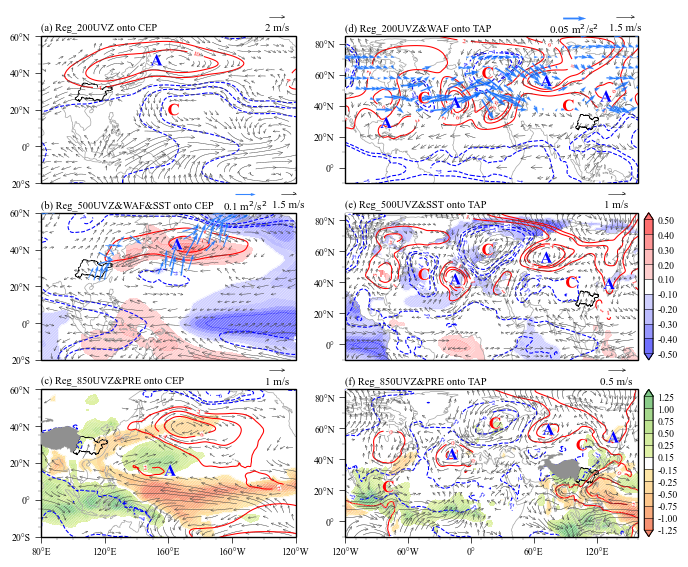

In [15]:
# 计算相关系数
corr_z_1 = np.zeros((len(Z['level']), len(Z['lat']), len(Z['lon'])))
corr_z_2 = np.zeros((len(Z['level']), len(Z['lat']), len(Z['lon'])))
reg_z_1 = np.zeros((len(Z['level']), len(Z['lat']), len(Z['lon'])))
reg_z_2 = np.zeros((len(Z['level']), len(Z['lat']), len(Z['lon'])))

corr_u_1 = np.zeros((len(U['level']), len(U['lat']), len(U['lon'])))
corr_u_2 = np.zeros((len(U['level']), len(U['lat']), len(U['lon'])))
reg_u_1 = np.zeros((len(U['level']), len(U['lat']), len(U['lon'])))
reg_u_2 = np.zeros((len(U['level']), len(U['lat']), len(U['lon'])))

corr_v_1 = np.zeros((len(V['level']), len(V['lat']), len(V['lon'])))
corr_v_2 = np.zeros((len(V['level']), len(V['lat']), len(V['lon'])))
reg_v_1 = np.zeros((len(V['level']), len(V['lat']), len(V['lon'])))
reg_v_2 = np.zeros((len(V['level']), len(V['lat']), len(V['lon'])))

corr_t_1 = np.zeros((len(T['level']), len(T['lat']), len(T['lon'])))
corr_t_2 = np.zeros((len(T['level']), len(T['lat']), len(T['lon'])))
reg_t_1 = np.zeros((len(T['level']), len(T['lat']), len(T['lon'])))
reg_t_2 = np.zeros((len(T['level']), len(T['lat']), len(T['lon'])))

corr_pre_1 = np.zeros((len(Pre['lat']), len(Pre['lon'])))
corr_pre_2 = np.zeros((len(Pre['lat']), len(Pre['lon'])))
reg_pre_1 = np.zeros((len(Pre['lat']), len(Pre['lon'])))
reg_pre_2 = np.zeros((len(Pre['lat']), len(Pre['lon'])))

corr_sst_1 = np.zeros((len(Sst['lat']), len(Sst['lon'])))
corr_sst_2 = np.zeros((len(Sst['lat']), len(Sst['lon'])))
reg_sst_1 = np.zeros((len(Sst['lat']), len(Sst['lon'])))
reg_sst_2 = np.zeros((len(Sst['lat']), len(Sst['lon'])))

corr_radio_1 = np.zeros((len(surface_radio['lat']), len(surface_radio['lon'])))
corr_radio_2 = np.zeros((len(surface_radio['lat']), len(surface_radio['lon'])))
reg_radio_1 = np.zeros((len(surface_radio['lat']), len(surface_radio['lon'])))
reg_radio_2 = np.zeros((len(surface_radio['lat']), len(surface_radio['lon'])))


## 东部型
K_series = K_type.sel(type=1)['K'].data
K_series = (K_series - np.mean(K_series))/np.std(K_series)
#### 大西洋降水

Sst = lonlat_trs(Sst, type='360->180')
Pre = lonlat_trs(Pre, type='360->180')
zone = [-110, 10, 20, 0]
corr_NPW = regress(K_series, Pre['pre'].sel(lon=slice(zone[0], zone[1]), lat=slice(zone[2], zone[3])).data)[0]
corr_NPW = np.where(corr_NPW > 0, corr_NPW, 0)
time_series = ((Pre.sel(lon=slice(zone[0], zone[1]), lat=slice(zone[2], zone[3]))- Pre.sel(lon=slice(zone[0], zone[1]), lat=slice(zone[2], zone[3])).mean(['year']))*corr_NPW).mean(['lat', 'lon'])['pre'].to_numpy()
# #### 大西洋暖异常
# zone = [-25, 10, 5, -5]
# corr_NPW = regress(K_series, Sst['sst'].sel(lon=slice(zone[0], zone[1]), lat=slice(zone[2], zone[3])).data)[0]
# time_series = ((Sst.sel(lon=slice(zone[0], zone[1]), lat=slice(zone[2], zone[3]))- Sst.sel(lon=slice(zone[0], zone[1]), lat=slice(zone[2], zone[3])).mean(['year']))*corr_NPW).mean(['lat', 'lon'])['sst'].to_numpy()
Sst = lonlat_trs(Sst, type='180->360')
Pre = lonlat_trs(Pre, type='180->360')
zone_1 = zone
time_series_1 = (time_series - np.mean(time_series))/np.std(time_series)
draw_zone_1 = [-120, 160, -10, 85]
c_lon_1 = 50
np.save(f'{PYFILE}/p2/data/type1_P_warm.npy', time_series_1)

#### 拉尼娜降水
# zone = [70, 360-140, 10, -10]
# corr_NPW = regress(K_series, Pre['pre'].sel(lon=slice(zone[0], zone[1]), lat=slice(zone[2], zone[3])).data)[0]
# time_series = ((Pre.sel(lon=slice(zone[0], zone[1]), lat=slice(zone[2], zone[3]))- Pre.sel(lon=slice(zone[0], zone[1]), lat=slice(zone[2], zone[3])).mean(['year']))*corr_NPW).mean(['lat', 'lon'])['pre'].to_numpy()
zone = [160, 360-85, 5, -5]
corr_LN = regress(K_series, Sst['sst'].sel(lon=slice(zone[0], zone[1]), lat=slice(zone[2], zone[3])).data)[0]
time_series = ((Sst.sel(lon=slice(zone[0], zone[1]), lat=slice(zone[2], zone[3]))- Sst.sel(lon=slice(zone[0], zone[1]), lat=slice(zone[2], zone[3])).mean(['year']))*corr_LN).mean(['lat', 'lon'])['sst'].to_numpy()
zone_2 = zone
time_series_2 = (time_series - np.mean(time_series))/np.std(time_series)
draw_zone_2 = [80, 360-130, -15, 60]
c_lon_2 = 160   #'''

np.save(f'{PYFILE}/p2/data/type1_LN.npy', time_series_2)

# 字体为新罗马
plt.rcParams['font.family'] = 'Times New Roman'
plt.close('all')
# Type1运行此模块
try:
    for j in tq.trange(len(Z['level'])):
        lev = Z['level'][j].data
        reg_z_1[j], corr_z_1[j] = regress(time_series_1, Z['z'].sel(level=lev).data)
        reg_u_1[j], corr_u_1[j] = regress(time_series_1, U['u'].sel(level=lev).data)
        reg_v_1[j], corr_v_1[j] = regress(time_series_1, V['v'].sel(level=lev).data)
        reg_t_1[j], corr_t_1[j] = regress(time_series_1, T['t'].sel(level=lev).data)
    reg_pre_1, corr_pre_1 = regress(time_series_1, Pre['pre'].data)
    reg_sst_1, corr_sst_1 = regress(time_series_1, Sst['sst'].data)
    reg_radio_1, corr_radio_1 = regress(time_series_1, (surface_radio['sshf'].data + surface_radio['slhf'].data) / 86400)
except:
    pass

for j in tq.trange(len(Z['level'])):
    lev = Z['level'][j].data
    reg_z_2[j], corr_z_2[j] = regress(time_series_2, Z['z'].sel(level=lev).data)
    reg_u_2[j], corr_u_2[j] = regress(time_series_2, U['u'].sel(level=lev).data)
    reg_v_2[j], corr_v_2[j] = regress(time_series_2, V['v'].sel(level=lev).data)
    reg_t_2[j], corr_t_2[j] = regress(time_series_2, T['t'].sel(level=lev).data)
reg_pre_2, corr_pre_2 = regress(time_series_2, Pre['pre'].data)
reg_sst_2, corr_sst_2 = regress(time_series_2, Sst['sst'].data)
reg_radio_2, corr_radio_2 = regress(time_series_2, (surface_radio['sshf'].data + surface_radio['slhf'].data) / 86400)

from climkit.significance_test import r_test

p_th = r_test(62, 0.1) # 62为样本量，0.1为显著性水平

Uc = xr.DataArray(U['u'].sel(level=[150, 200, 500]).mean('year').data,
                    coords=[('level', [150, 200, 500]),
                            ('lat', U['lat'].data),
                            ('lon', U['lon'].data)])
Vc = xr.DataArray(V['v'].sel(level=[150, 200, 500]).mean('year').data,
                    coords=[('level', [150, 200, 500]),
                            ('lat', V['lat'].data),
                            ('lon', V['lon'].data)])
Tc = xr.DataArray(T['t'].sel(level=[150, 200, 500]).mean('year').data,
                    coords=[('level', [150, 200, 500]),
                            ('lat', T['lat'].data),
                            ('lon', T['lon'].data)])


# type1绘图
if 1:

    fig = plt.figure(figsize=(8.88*1.25*(16*10/8+30)/72, 5*1.3))
    # fig.subplots_adjust(hspace=0.4)  # Increase vertical spacing between subplots
    # plt.subplots_adjust(wspace=0.1, hspace=0.05)
    lon_stick = np.array([0, 60, 120, 360-60, 360-120])
    lat_stick = np.array([0, 20, 40, 60, 80])
    #子图间距
    gs = gridspec.GridSpec(3, 2, width_ratios=[16*10/8/36, 23/36], height_ratios=[1, 1, 1], hspace=0.2, wspace=0.18)
    ax1 = fig.add_subplot(gs[0, 1], projection=ccrs.PlateCarree(central_longitude=c_lon_1))
    # 统一加粗所有四个边框
    for spine in ax1.spines.values():
        spine.set_linewidth(1)  # 设置边框线宽
    ax1.set_title(f"(d) Reg_200UVZ&WAF onto TAP", fontsize=7.5, loc='left', y=0.98)
    ax1.set_extent(draw_zone_1, crs=ccrs.PlateCarree())
    ax1.set_aspect('auto')
    # ax1.add_feature(cfeature.LAND.with_scale('110m'), color='lightgray', lw=0.05)
    ax1.add_feature(cfeature.COASTLINE.with_scale('110m'), linewidth=0.5, color="#a4a4a4")
    ax1.add_geometries(Reader(f'{PYFILE}/map/self/长江_TP/长江_tp.shp').geometries(), ccrs.PlateCarree(),
                      facecolor='none', edgecolor='black', linewidth=.5)
    # rec(ax1, zone_1, color='green')
    latlon_fmt(ax1, None, lat_stick, MultipleLocator(45), MultipleLocator(10), MultipleLocator(30), MultipleLocator(10))
    # 3Dwaf
    GEOa = xr.DataArray(reg_z_1[1:4, :, :],
                        coords=[('level', [150, 200, 500]),
                                ('lat', U['lat'].data),
                                ('lon', U['lon'].data)])
    waf_x, waf_y, waf_z = TN_WAF_3D(Uc, Vc, GEOa, Tc)
    waf_x = lonlat_trs(waf_x, type='360->180')
    waf_y = lonlat_trs(waf_y, type='360->180')
    reg_z_, lon = add_cyclic_point(reg_z_1[2, :, :], coord=Z['lon'])
    corr_z_, lon = add_cyclic_point(corr_z_1[2, :, :], coord=Z['lon'])
    lev_z = np.array([-10, -8, -6, -4, -2, -1, 1, 2, 4, 6, 8, 10])

    z_high = ax1.contour(lon, Z['lat'], reg_z_/9.8, colors='red', levels=[2, 6, 8], linewidths=0.77, transform=ccrs.PlateCarree(central_longitude=0))
    z_low = ax1.contour(lon, Z['lat'], reg_z_/9.8, colors='blue', levels=[-8, -5, -4], linewidths=0.77, transform=ccrs.PlateCarree(central_longitude=0), ls='--')
    clabel1 = z_high.clabel(inline=1, fontsize=5)
    clabel2 = z_low.clabel(inline=1, fontsize=5)
    clabels = clabel1 + clabel2
    for label in clabels:
        label.set_bbox(dict(facecolor='white',  # 背景色为白色
                            edgecolor='none',  # 无边框
                            pad=0,  # 标签与背景的间距
                            alpha=1,  # 背景的透明度 (0.8表示80%不透明)
                            zorder=20
                            ))

    # # Z
    # z_cont = ax1.contour(lon, Z['lat'], reg_z_/9.8, colors='white', levels=np.array([-10, -8, -6, -4, -2, 2, 4, 6, 8, 10]), linestyles='solid', linewidths=0.2, transform=ccrs.PlateCarree(central_longitude=0))
    # Z_contf = ax1.contourf(lon, Z['lat'], reg_z_/9.8, cmap=cmaps.temp_diff_18lev[5:-5], levels=lev_z, extend='both', alpha=0.75, transform=ccrs.PlateCarree(central_longitude=0))
    # p_test = np.where(np.abs(corr_z_) > p_th, 0, np.nan)
    #ax2.quiver(lon, Sst['lat'], p_test, p_test, transform=ccrs.PlateCarree(central_longitude=0), color='w', scale=20, headlength=2, headaxislength=2, regrid_shape=60)
    # 显著性
    # plt.rcParams['hatch.linewidth'] = 0.2
    # plt.rcParams['hatch.color'] = '#FFFFFF'
    # p_hatches = ax1.contourf(lon, Z['lat'], p_test, levels=[0, 1], hatches=['////////////', None], colors="none", add_colorbar=False, transform=ccrs.PlateCarree(central_longitude=0), edgecolor='none',  linewidths=0)

    wind = Curlyquiver(ax1, U['lon'], U['lat'], reg_u_1[2, :, :], reg_v_1[2, :, :], thinning=[['20%', '80%'], 'range'],
                                  center_lon=c_lon_1, arrowsize=.8, scale=5*.75, linewidth=0.3, regrid=15,
                                   color='#454545', nanmax=20/3, MinDistance=[0.5, 0.1])
    wind.key(fig, U=1.5, label='1.5 m/s', lr=0.8, ud=7.87, edgecolor='none', arrowsize=.5, linewidth=0.4,color='k', fontproperties={'size': 8})
    # WAF_cq = Curlyquiver(ax1, waf_x['lon'], waf_x['lat'][:180],
    #                               waf_x[1][:180, :], waf_y[1][:180, :], alpha=0.5,
    #                               regrid=15, center_lon=c_lon_1, arrowsize=.8, scale=3, linewidth=1., thinning=['35%', 'min'],
    #                               color='purple', nanmax=.2, MinDistance=[0.8, 0.1])
    # WAF_cq.key(fig, U=.02, label='0.02 m$^2$/s$^2$', lr=1.8, ud=7.87, edgecolor='none', arrowsize=.5, linewidth=0.4)
    waf_x_ = waf_x[1][:115, :]
    waf_y_ = waf_y[1][:115, :]
    waf_lat = waf_x['lat'][:115]
    waf_lon = waf_x['lon']
    waf_mag = np.sqrt(waf_x_**2 + waf_y_**2)
    low = np.nanpercentile(waf_mag.values, 95)
    high = np.nanpercentile(waf_mag.values, 100)
    mask = (waf_mag > low) & (waf_mag <= high) & (waf_x_ >= 0)
    waf_x_masked = waf_x_.where(mask)
    waf_y_masked = waf_y_.where(mask)
    WAF_Q = ax1.quiver(
                        waf_lon,
                        waf_lat,
                        waf_x_masked,
                        waf_y_masked,
                        scale=0.65, linewidth=0.15, color='#0066ff', edgecolors='white', pivot='mid',
                        transform=ccrs.PlateCarree(central_longitude=0), alpha=0.8, width=.007,
                        regrid_shape=8, zorder=40
                        )

    low = np.nanpercentile(waf_mag.values, 80)
    high = np.nanpercentile(waf_mag.values, 95)
    mask = (waf_mag > low) & (waf_mag <= high) & (waf_x_ >= 0)
    waf_x_masked = waf_x_.where(mask)
    waf_y_masked = waf_y_.where(mask)
    WAF_Q = ax1.quiver(
                        waf_lon,
                        waf_lat,
                        waf_x_masked,
                        waf_y_masked,
                        scale=0.65, linewidth=0.15, color='#0066ff', edgecolors='white', pivot='mid',
                        transform=ccrs.PlateCarree(central_longitude=0), alpha=0.8, width=.006,
                        regrid_shape=13, zorder=40
                        )

    low = np.nanpercentile(waf_mag.values, 25)
    high = np.nanpercentile(waf_mag.values, 80)
    mask = (waf_mag > low) & (waf_mag <= high) & (waf_x_ >= 0)
    waf_x_masked = waf_x_.where(mask)
    waf_y_masked = waf_y_.where(mask)
    WAF_Q = ax1.quiver(
                        waf_lon,
                        waf_lat,
                        waf_x_masked,
                        waf_y_masked,
                        scale=0.65, linewidth=0.15, color='#0066ff', edgecolors='white', pivot='mid',
                        transform=ccrs.PlateCarree(central_longitude=0), alpha=0.8, width=.005,
                        regrid_shape=15, zorder=40
                        )

    ax1.quiverkey(WAF_Q, X=0.78, Y=1.125, U=0.05, label='0.05 m$^2$/s$^2$', labelpos='S', coordinates='axes', color='#0066ff', labelcolor='black', fontproperties={'size': 8}, labelsep=0.045)
    # 边框显示为黑色
    ax1.grid(False)
    for spine in ax1.spines.values():
        spine.set_edgecolor('black')
    # # 色标
    # ax1_colorbar = inset_axes(ax1, width="3%", height="100%", loc='lower left', bbox_to_anchor=(1.02, 0., 1, 1), bbox_transform=ax1.transAxes, borderpad=0)
    # cb1 = plt.colorbar(Z_contf, cax=ax1_colorbar, orientation='vertical', drawedges=True)
    # cb1.outline.set_edgecolor('black')  # 将colorbar边框调为黑色
    # cb1.dividers.set_color('black') # 将colorbar内间隔线调为黑色
    # cb1.locator = ticker.FixedLocator(lev_z)
    # # cb1.locator = ticker.FixedLocator(np.array([-25, -20, -15, -10, -5, 5, 10, 15, 20, 25]))
    # # cb1.set_ticklabels(['-30', '-25', '-20', '-15', '-10', '-5', '5', '10', '15', '20', '25', '30'])
    # cb1.ax.tick_params(length=0, labelsize=6)  # length为刻度线的长度


    ax4 = fig.add_subplot(gs[1, 1], projection=ccrs.PlateCarree(central_longitude=c_lon_1))
    # 统一加粗所有四个边框
    for spine in ax4.spines.values():
        spine.set_linewidth(1)  # 设置边框线宽
    ax4.set_title(f"(e) Reg_500UVZ&SST onto TAP", fontsize=7.5, loc='left', y=0.98)
    ax4.set_extent(draw_zone_1, crs=ccrs.PlateCarree())
    ax4.set_aspect('auto')
    # ax4.add_feature(cfeature.LAND.with_scale('110m'), color='lightgray', lw=0.05)
    ax4.add_feature(cfeature.COASTLINE.with_scale('110m'), linewidth=0.5, color='#a4a4a4')
    ax4.add_geometries(Reader(f'{PYFILE}/map/self/长江_TP/长江_tp.shp').geometries(), ccrs.PlateCarree(),facecolor='none', edgecolor='black', linewidth=.5)
    # rec(ax4, zone_1, color='green')

    lev_z = np.array([-10, -8, -6, -4, -2, 2, 4, 6, 8, 10])
    latlon_fmt(ax4, None, lat_stick, MultipleLocator(45), MultipleLocator(10), MultipleLocator(30), MultipleLocator(10))
    reg_z_, lon = add_cyclic_point(reg_z_1[3, :, :], coord=Z['lon'])
    corr_z_, lon = add_cyclic_point(corr_z_1[3, :, :], coord=Z['lon'])
    # z
    z_high = ax4.contour(lon, Z['lat'], reg_z_/9.8, colors='red', levels=[1, 3, 4], linewidths=0.77, transform=ccrs.PlateCarree(central_longitude=0))
    z_low = ax4.contour(lon, Z['lat'], reg_z_/9.8, colors='blue', levels=[-5, -3, -2], linewidths=0.77, transform=ccrs.PlateCarree(central_longitude=0), ls='--')
    clabel1 = z_high.clabel(inline=1, fontsize=5)
    clabel2 = z_low.clabel(inline=1, fontsize=5)
    clabels = clabel1 + clabel2
    for label in clabels:
        label.set_bbox(dict(facecolor='white',  # 背景色为白色
                            edgecolor='none',  # 无边框
                            pad=0,  # 标签与背景的间距
                            alpha=1,  # 背景的透明度 (0.8表示80%不透明)
                            zorder=20
                            ))

    reg_sst_, lon = add_cyclic_point(reg_sst_1[:, :], coord=Sst['lon'])
    corr_sst_, lon = add_cyclic_point(corr_sst_1[:, :], coord=Sst['lon'])
    # reg_sst_ = np.where((np.abs(reg_sst_) < .1), np.nan, reg_sst_)
    # sst
    sst = ax4.contourf(lon, Sst['lat'], reg_sst_, cmap=cmaps.GMT_polar[2:10] + cmaps.CBR_wet[0] + cmaps.GMT_polar[10:-2], levels=[-.5, -.4, -.3, -.2, -.1, .1, .2, .3, .4, .5], extend='both', alpha=0.75, transform=ccrs.PlateCarree(central_longitude=0))
    p_test = np.where(np.abs(corr_sst_) > p_th, 0, np.nan)
    #ax4.quiver(lon, Sst['lat'], p_test, p_test, transform=ccrs.PlateCarree(central_longitude=0), color='w', scale=20, headlength=2, headaxislength=2, regrid_shape=60)
    # 显著性
    plt.rcParams['hatch.linewidth'] = 0.2
    plt.rcParams['hatch.color'] = '#FFFFFF'
    p_hatches = ax4.contourf(lon, Sst['lat'], p_test, levels=[0, 1], hatches=['////////////', None], colors="none", add_colorbar=False, transform=ccrs.PlateCarree(central_longitude=0), edgecolor='none',  linewidths=0)


    wind = Curlyquiver(ax4, U['lon'], U['lat'], reg_u_1[3, :, :], reg_v_1[3, :, :], thinning=['20%', 'min'],
                                  center_lon=c_lon_1, arrowsize=.8, scale=2.5, linewidth=0.3, regrid=20,
                                  color='#454545', nanmax=wind.nanmax, MinDistance=[0.5, 0.1])
    wind.key(fig, U=1, label='1 m/s', ud=7.87, edgecolor='none', arrowsize=.5, color='k', linewidth=0.4, fontproperties={'size': 8})

    # 边框显示为黑色
    ax4.grid(False)
    for spine in ax4.spines.values():
        spine.set_edgecolor('black')

    # 色标
    ax4_colorbar = inset_axes(ax4, width="3%", height="100%", loc='lower left', bbox_to_anchor=(1.02, 0., 1, 1), bbox_transform=ax4.transAxes, borderpad=0)
    cb4 = plt.colorbar(sst, cax=ax4_colorbar, orientation='vertical', drawedges=True)
    cb4.outline.set_edgecolor('black')  # 将colorbar边框调为黑色
    cb4.dividers.set_color('black') # 将colorbar内间隔线调为黑色
    cb4.locator = ticker.FixedLocator(np.array([-.5, -.4, -.3, -.2, -.1, .1, .2, .3, .4, .5]))
    cb4.set_ticklabels([str(f'{i:.2f}') for i in [-.5, -.4, -.3, -.2, -.1, .1, .2, .3, .4, .5]])
    cb4.ax.tick_params(length=0, labelsize=7)  # length为刻度线的长度


    axf = fig.add_subplot(gs[2, 1], projection=ccrs.PlateCarree(central_longitude=c_lon_1))
    # 统一加粗所有四个边框
    for spine in axf.spines.values():
        spine.set_linewidth(1)  # 设置边框线宽
    axf.set_title(f"(f) Reg_850UVZ&PRE onto TAP", fontsize=7.5, loc='left', y=0.98)
    axf.set_extent(draw_zone_1, crs=ccrs.PlateCarree())
    axf.set_aspect('auto')
    # axf.add_feature(cfeature.LAND.with_scale('110m'), color='lightgray', lw=0.05)
    axf.add_feature(cfeature.COASTLINE.with_scale('110m'), linewidth=0.5, color="#a4a4a4")
    axf.add_geometries(Reader(f'{PYFILE}/map/self/长江_TP/长江_tp.shp').geometries(), ccrs.PlateCarree(),
                      facecolor='none', edgecolor='black', linewidth=.5)
    # rec(axf, zone_1, color='green')
    latlon_fmt(axf, lon_stick, lat_stick, MultipleLocator(45), MultipleLocator(10), MultipleLocator(30), MultipleLocator(10))
    reg_z_, lon = add_cyclic_point(reg_z_1[4, :, :], coord=Z['lon'])
    corr_z_, lon = add_cyclic_point(corr_z_1[4, :, :], coord=Z['lon'])
    lev_z = np.array([-10, -8, -6, -4, -2, -1, 1, 2, 4, 6, 8, 10])

    z_high = axf.contour(lon, Z['lat'], reg_z_/9.8, colors='red', levels=[0, 2], linewidths=0.77, transform=ccrs.PlateCarree(central_longitude=0))
    z_low = axf.contour(lon, Z['lat'], reg_z_/9.8, colors='blue', levels=[-6, -2], linewidths=0.77, transform=ccrs.PlateCarree(central_longitude=0), ls='--')
    clabel1 = z_high.clabel(inline=1, fontsize=5)
    clabel2 = z_low.clabel(inline=1, fontsize=5)
    clabels = clabel1 + clabel2
    for label in clabels:
        label.set_bbox(dict(facecolor='white',  # 背景色为白色
                            edgecolor='none',  # 无边框
                            pad=0,  # 标签与背景的间距
                            alpha=1,  # 背景的透明度 (0.8表示80%不透明)
                            zorder=20
                            ))

    #pre
    reg_pre_, lon = add_cyclic_point(reg_pre_1[:, :], coord=Pre['lon'])
    corr_pre_, lon = add_cyclic_point(corr_pre_1[:, :], coord=Pre['lon'])

    # pre
    pre = axf.contourf(lon, Pre['lat'], reg_pre_, cmap=cmaps.MPL_RdYlGn[22+0:56] + cmaps.CBR_wet[0] + cmaps.MPL_RdYlGn[72:106-0], alpha=0.75, levels=[-1.25, -1., -.75, -.5, -.25, -.15, .15, .25, .5, .75, 1., 1.25], extend='both', transform=ccrs.PlateCarree(central_longitude=0))
    pre_edge = axf.contour(lon, Pre['lat'], reg_pre_, colors='white', levels=[-1.25, -1., -.75, -.5, -.25, .25, .5, .75, 1., 1.25], linestyles='solid',linewidths=0.2, transform=ccrs.PlateCarree(central_longitude=0))
    p_test = np.where(np.abs(corr_pre_) > p_th, 0, np.nan)
    #ax3.quiver(lon, Pre['lat'], p_test, p_test, transform=ccrs.PlateCarree(central_longitude=0), color='w', scale=20, headlength=2, headaxislength=2, regrid_shape=60)
    # 显著性
    p_hatches = axf.contourf(lon, Pre['lat'], p_test, levels=[0, 1], hatches=['////////////', None], colors="none", add_colorbar=False, transform=ccrs.PlateCarree(central_longitude=0), edgecolor='none',  linewidths=0)
    plt.rcParams['hatch.linewidth'] = 0.2
    plt.rcParams['hatch.color'] = '#FFFFFF'

    wind = Curlyquiver(axf, U['lon'], U['lat'], reg_u_1[4, :, :], reg_v_1[4, :, :], thinning=[['20%', '100%'], 'range'],
                                  center_lon=c_lon_1, arrowsize=1., scale=2.5/2, linewidth=0.3, regrid=20,
                                   color='#454545', nanmax=20/3, MinDistance=[0.5, 0.1])
    wind.key(fig, U=0.5, label='0.5 m/s', ud=7.87, edgecolor='none', arrowsize=.5, linewidth=0.4,color='k', fontproperties={'size': 8})

    # 边框显示为黑色
    axf.grid(False)
    for spine in axf.spines.values():
        spine.set_edgecolor('black')
    axf.add_geometries(Reader(f'{PYFILE}/map/地图边界数据/青藏高原边界数据总集/TPBoundary_2500m/TPBoundary_2500m.shp').geometries(),
                               ccrs.PlateCarree(), facecolor='#909090', edgecolor='#909090', linewidth=.1, hatch='.', zorder=10)
    # # 色标
    axf_colorbar = inset_axes(axf, width="3%", height="100%", loc='lower left', bbox_to_anchor=(1.02, 0., 1, 1), bbox_transform=axf.transAxes, borderpad=0)
    cb1 = plt.colorbar(pre, cax=axf_colorbar, orientation='vertical', drawedges=True)
    cb1.outline.set_edgecolor('black')  # 将colorbar边框调为黑色
    cb1.dividers.set_color('black') # 将colorbar内间隔线调为黑色
    cb1.locator = ticker.FixedLocator([-1.25, -1., -.75, -.5, -.25, -.15, .15, .25, .5, .75, 1., 1.25])
    cb1.set_ticklabels([str(f'{i:.2f}') for i in [-1.25, -1., -.75, -.5, -.25, -.15, .15, .25, .5, .75, 1., 1.25]])
    # cb1.locator = ticker.FixedLocator(np.array([-25, -20, -15, -10, -5, 5, 10, 15, 20, 25]))
    # cb1.set_ticklabels(['-30', '-25', '-20', '-15', '-10', '-5', '5', '10', '15', '20', '25', '30'])
    cb1.ax.tick_params(length=0, labelsize=7)  # length为刻度线的长度

    ######################################################################################################################################################################################################
    ######################################################################################################################################################################################################
    ######################################################################################################################################################################################################

    lon_stick = np.array([80, 120, 160, 200, 240])
    lat_stick = np.array([-20, 0, 20, 40, 60])

    axa = fig.add_subplot(gs[0, 0], projection=ccrs.PlateCarree(central_longitude=c_lon_2))
        # 统一加粗所有四个边框
    for spine in axa.spines.values():
        spine.set_linewidth(1)  # 设置边框线宽
    axa.set_title(f"(a) Reg_200UVZ onto CEP", fontsize=7.5, loc='left', y=0.98)
    axa.set_extent(draw_zone_2, crs=ccrs.PlateCarree())
    axa.set_aspect('auto')
    # ax2.add_feature(cfeature.LAND.with_scale('110m'), color='lightgray', lw=0.05)
    axa.add_feature(cfeature.COASTLINE.with_scale('110m'), linewidth=0.5, color="#a4a4a4")
    axa.add_geometries(Reader(f'{PYFILE}/map/self/长江_TP/长江_tp.shp').geometries(), ccrs.PlateCarree(),facecolor='none', edgecolor='black', linewidth=.5)
    # rec(ax2, zone_1, color='green')
    reg_z_, lon = add_cyclic_point(reg_z_2[1, :, :], coord=Z['lon'])
    corr_z_, lon = add_cyclic_point(corr_z_2[1, :, :], coord=Z['lon'])
    lev_z = np.array([-10, -8, -6, -4, -2, -1, 1, 2, 4, 6, 8, 10])
    latlon_fmt(axa, None, lat_stick, MultipleLocator(45), MultipleLocator(10), MultipleLocator(30), MultipleLocator(5))
    # # z
    z_high = axa.contour(lon, Z['lat'], reg_z_/9.8, colors='red', levels=[4, 10], linewidths=0.77, transform=ccrs.PlateCarree(central_longitude=0))
    z_low = axa.contour(lon, Z['lat'], reg_z_/9.8, colors='blue', levels=[-14, -10, -6], linewidths=0.77, transform=ccrs.PlateCarree(central_longitude=0), ls='--')
    clabel1 = z_high.clabel(inline=1, fontsize=5)
    clabel2 = z_low.clabel(inline=1, fontsize=5)
    clabels = clabel1 + clabel2
    for label in clabels:
        label.set_bbox(dict(facecolor='white',  # 背景色为白色
                            edgecolor='none',  # 无边框
                            pad=0,  # 标签与背景的间距
                            alpha=1,  # 背景的透明度 (0.8表示80%不透明)
                            zorder=20
                            ))

    # # Z
    # z_cont = axa.contour(lon, Z['lat'], reg_z_/9.8, colors='white', levels=lev_z, linestyles='solid', linewidths=0.2, transform=ccrs.PlateCarree(central_longitude=0))
    # Z_contf = axa.contourf(lon, Z['lat'], reg_z_/9.8, cmap=cmaps.temp_diff_18lev[5:-5], levels=lev_z, extend='both', alpha=0.75, transform=ccrs.PlateCarree(central_longitude=0))
    # p_test = np.where(np.abs(corr_z_) > p_th, 0, np.nan)
    # #ax2.quiver(lon, Sst['lat'], p_test, p_test, transform=ccrs.PlateCarree(central_longitude=0), color='w', scale=20, headlength=2, headaxislength=2, regrid_shape=60)
    # # 显著性
    # plt.rcParams['hatch.linewidth'] = 0.2
    # plt.rcParams['hatch.color'] = '#FFFFFF'
    # p_hatches = axa.contourf(lon, Z['lat'], p_test, levels=[0, 1], hatches=['////////////', None], colors="none", add_colorbar=False, transform=ccrs.PlateCarree(central_longitude=0), edgecolor='none',  linewidths=0)

    # reg_sst_, lon = add_cyclic_point(reg_sst_2[:, :], coord=Sst['lon'])
    # corr_sst_, lon = add_cyclic_point(corr_sst_2[:, :], coord=Sst['lon'])
    # reg_sst_ = np.where((np.abs(reg_sst_) < .1), np.nan, reg_sst_)
    # # sst
    # sst = ax2.contourf(lon, Sst['lat'], reg_sst_, cmap=cmaps.GMT_polar[2:10] + cmaps.CBR_wet[0] + cmaps.GMT_polar[10:-2], levels=[-.5, -.4, -.3, -.2, -.1, .1, .2, .3, .4, .5], extend='both', alpha=0.75, transform=ccrs.PlateCarree(central_longitude=0))
    # p_test = np.where(np.abs(corr_sst_) > p_th, 0, np.nan)
    # #ax2.quiver(lon, Sst['lat'], p_test, p_test, transform=ccrs.PlateCarree(central_longitude=0), color='w', scale=20, headlength=2, headaxislength=2, regrid_shape=60)
    # # 显著性
    # plt.rcParams['hatch.linewidth'] = 0.2
    # plt.rcParams['hatch.color'] = '#FFFFFF'
    # p_hatches = ax2.contourf(lon, Sst['lat'], p_test, levels=[0, 1], hatches=['////////////', None], colors="none", add_colorbar=False, transform=ccrs.PlateCarree(central_longitude=0), edgecolor='none',  linewidths=0)

    # wind
    GEOa2 = xr.DataArray(reg_z_2[1:4, :, :],
                        coords=[('level', [150, 200, 500]),
                                ('lat', U['lat'].data),
                                ('lon', U['lon'].data)])
    waf_x, waf_y, waf_z = TN_WAF_3D(Uc, Vc, GEOa2, Tc)
    waf_x = lonlat_trs(waf_x, type='360->180')
    waf_y = lonlat_trs(waf_y, type='360->180')
    wind = Curlyquiver(axa, U['lon'], U['lat'], reg_u_2[2, :, :], reg_v_2[2, :, :], thinning=['15%', 'min'],
                                  center_lon=c_lon_2, arrowsize=.8, scale=5, linewidth=0.3, regrid=25,
                                  color='#454545', nanmax=wind.nanmax, MinDistance=[0.7, 0.1])
    wind.key(fig, U=2, label='2 m/s', ud=7.87, edgecolor='none', arrowsize=.5, color='k', linewidth=0.4, fontproperties={'size': 8})
    # WAF_cq = Curlyquiver(axa, waf_x['lon'], waf_x['lat'][:180],
    #                               waf_x[1][:180, :], waf_y[1][:180, :], thinning=['50%', 'min'], alpha=0.5,
    #                               regrid=15, center_lon=c_lon_2, arrowsize=.8, scale=7.5, linewidth=1.,
    #                               color='purple', nanmax=.2, MinDistance=[0.8, 0.1])
    # WAF_cq.key(fig, U=.05, label='0.05 m$^2$/s$^2$', lr=1.8, ud=7.87, edgecolor='none', arrowsize=.5, linewidth=0.4)
    # 边框显示为黑色
    axa.grid(False)
    for spine in axa.spines.values():
        spine.set_edgecolor('black')

    # # 色标
    # ax2_colorbar = inset_axes(ax2, width="3%", height="100%", loc='lower left', bbox_to_anchor=(1.02, 0., 1, 1), bbox_transform=ax2.transAxes, borderpad=0)
    # cb2 = plt.colorbar(Z_contf, cax=ax2_colorbar, orientation='vertical', drawedges=True)
    # cb2.outline.set_edgecolor('black')  # 将colorbar边框调为黑色
    # cb2.dividers.set_color('black') # 将colorbar内间隔线调为黑色
    # # cb1.locator = ticker.FixedLocator(np.array([-25, -20, -15, -10, -5, 5, 10, 15, 20, 25]))
    # # cb1.set_ticklabels(['-30', '-25', '-20', '-15', '-10', '-5', '5', '10', '15', '20', '25', '30'])
    # cb2.ax.tick_params(length=0, labelsize=6)  # length为刻度线的长度


    ax2 = fig.add_subplot(gs[1, 0], projection=ccrs.PlateCarree(central_longitude=c_lon_2))
        # 统一加粗所有四个边框
    for spine in ax2.spines.values():
        spine.set_linewidth(1)  # 设置边框线宽
    ax2.set_title(f"(b) Reg_500UVZ&WAF&SST onto CEP", fontsize=7.5, loc='left', y=0.98)
    ax2.set_extent(draw_zone_2, crs=ccrs.PlateCarree())
    ax2.set_aspect('auto')
    # ax2.add_feature(cfeature.LAND.with_scale('110m'), color='lightgray', lw=0.05)
    ax2.add_feature(cfeature.COASTLINE.with_scale('110m'), linewidth=0.5, color="#a4a4a4")
    ax2.add_geometries(Reader(f'{PYFILE}/map/self/长江_TP/长江_tp.shp').geometries(), ccrs.PlateCarree(),facecolor='none', edgecolor='black', linewidth=.5)
    # rec(ax2, zone_1, color='green')
    reg_z_, lon = add_cyclic_point(reg_z_2[3, :, :], coord=Z['lon'])
    corr_z_, lon = add_cyclic_point(corr_z_2[3, :, :], coord=Z['lon'])
    lev_z = np.array([-10, -8, -6, -4, -2, -1, 1, 2, 4, 6, 8, 10])
    latlon_fmt(ax2, None, lat_stick, MultipleLocator(45), MultipleLocator(10), MultipleLocator(30), MultipleLocator(5))
    # # z
    z_high = ax2.contour(lon, Z['lat'], reg_z_/9.8, colors='red', levels=[4, 10], linewidths=0.77, transform=ccrs.PlateCarree(central_longitude=0))
    z_low = ax2.contour(lon, Z['lat'], reg_z_/9.8, colors='blue', levels=[-6, -4, -3], linewidths=0.77, transform=ccrs.PlateCarree(central_longitude=0), ls='--')
    clabel1 = z_high.clabel(inline=1, fontsize=5)
    clabel2 = z_low.clabel(inline=1, fontsize=5)
    clabels = clabel1 + clabel2
    for label in clabels:
        label.set_bbox(dict(facecolor='white',  # 背景色为白色
                            edgecolor='none',  # 无边框
                            pad=0,  # 标签与背景的间距
                            alpha=1,  # 背景的透明度 (0.8表示80%不透明)
                            zorder=20
                            ))

    # # Z
    # z_cont = ax2.contour(lon, Z['lat'], reg_z_/9.8, colors='white', levels=lev_z, linestyles='solid', linewidths=0.2, transform=ccrs.PlateCarree(central_longitude=0))
    # Z_contf = ax2.contourf(lon, Z['lat'], reg_z_/9.8, cmap=cmaps.temp_diff_18lev[5:-5], levels=lev_z, extend='both', alpha=0.75, transform=ccrs.PlateCarree(central_longitude=0))
    # p_test = np.where(np.abs(corr_z_) > p_th, 0, np.nan)
    # #ax2.quiver(lon, Sst['lat'], p_test, p_test, transform=ccrs.PlateCarree(central_longitude=0), color='w', scale=20, headlength=2, headaxislength=2, regrid_shape=60)
    # # 显著性
    # plt.rcParams['hatch.linewidth'] = 0.2
    # plt.rcParams['hatch.color'] = '#FFFFFF'
    # p_hatches = ax2.contourf(lon, Z['lat'], p_test, levels=[0, 1], hatches=['////////////', None], colors="none", add_colorbar=False, transform=ccrs.PlateCarree(central_longitude=0), edgecolor='none',  linewidths=0)

    reg_sst_, lon = add_cyclic_point(reg_sst_2[:, :], coord=Sst['lon'])
    corr_sst_, lon = add_cyclic_point(corr_sst_2[:, :], coord=Sst['lon'])
    # reg_sst_ = np.where((np.abs(reg_sst_) < .1), np.nan, reg_sst_)
    # sst
    sst = ax2.contourf(lon, Sst['lat'], reg_sst_, cmap=cmaps.GMT_polar[2:10] + cmaps.CBR_wet[0] + cmaps.GMT_polar[10:-2], levels=[-.5, -.4, -.3, -.2, -.1, .1, .2, .3, .4, .5], extend='both', alpha=0.75, transform=ccrs.PlateCarree(central_longitude=0))
    p_test = np.where(np.abs(corr_sst_) > p_th, 0, np.nan)
    #ax2.quiver(lon, Sst['lat'], p_test, p_test, transform=ccrs.PlateCarree(central_longitude=0), color='w', scale=20, headlength=2, headaxislength=2, regrid_shape=60)
    # 显著性
    plt.rcParams['hatch.linewidth'] = 0.2
    plt.rcParams['hatch.color'] = '#FFFFFF'
    p_hatches = ax2.contourf(lon, Sst['lat'], p_test, levels=[0, 1], hatches=['////////////', None], colors="none", add_colorbar=False, transform=ccrs.PlateCarree(central_longitude=0), edgecolor='none',  linewidths=0)

    # wind
    GEOa2 = xr.DataArray(reg_z_2[1:4, :, :],
                        coords=[('level', [150, 200, 500]),
                                ('lat', U['lat'].data),
                                ('lon', U['lon'].data)])
    waf_x, waf_y, waf_z = TN_WAF_3D(Uc, Vc, GEOa2, Tc)
    waf_x = lonlat_trs(waf_x, type='360->180')
    waf_y = lonlat_trs(waf_y, type='360->180')
    wind = Curlyquiver(ax2, U['lon'], U['lat'], reg_u_2[3, :, :], reg_v_2[3, :, :], thinning=['25%', 'min'],
                                  center_lon=c_lon_2, arrowsize=.8, scale=3.75, linewidth=0.3, regrid=20,
                                  color='#454545', nanmax=wind.nanmax, MinDistance=[0.5, 0.1])
    wind.key(fig, U=1.5, label='1.5 m/s', lr=0.7, ud=7.87, edgecolor='none', arrowsize=.5, color='k', linewidth=0.4, fontproperties={'size': 8})
    # WAF_cq = Curlyquiver(ax2, waf_x['lon'], waf_x['lat'][:180],
    #                               waf_x[2][:180, :], waf_y[2][:180, :], thinning=['65%', 'min'], alpha=0.5,
    #                               regrid=15, center_lon=c_lon_2, arrowsize=.8, scale=7.5, linewidth=1.,
    #                               color='purple', nanmax=.2, MinDistance=[0.8, 0.1])
    # WAF_cq.key(fig, U=.05, label='0.05 m$^2$/s$^2$', lr=1.8, ud=7.7, edgecolor='none', arrowsize=.5, linewidth=0.4)
    waf_x_ = waf_x[2][:180, :]
    waf_y_ = waf_y[2][:180, :]
    waf_lat = waf_x['lat'][:180]
    waf_lon = waf_x['lon']
    waf_mag = np.sqrt(waf_x_**2 + waf_y_**2)
    low = np.nanpercentile(waf_mag.values, 93)
    high = np.nanpercentile(waf_mag.values, 98)
    mask = (waf_mag > low) & (waf_mag <= high) & (waf_x_ >= 0)
    waf_x_masked = waf_x_.where(mask)
    waf_y_masked = waf_y_.where(mask)
    WAF_Q = ax2.quiver(
                        waf_lon,
                        waf_lat,
                        waf_x_masked,
                        waf_y_masked,
                        scale=1.3, linewidth=0.15, color='#0066ff', edgecolors='white', pivot='mid',
                        transform=ccrs.PlateCarree(central_longitude=0), alpha=0.8, width=.006,
                        regrid_shape=15, zorder=40
                        )

    low = np.nanpercentile(waf_mag.values, 86)
    high = np.nanpercentile(waf_mag.values, 93)
    mask = (waf_mag > low) & (waf_mag <= high) & (waf_x_ >= 0)
    waf_x_masked = waf_x_.where(mask)
    waf_y_masked = waf_y_.where(mask)
    WAF_Q = ax2.quiver(
                        waf_lon,
                        waf_lat,
                        waf_x_masked,
                        waf_y_masked,
                        scale=1.3, linewidth=0.15, color='#0066ff', edgecolors='white', pivot='mid',
                        transform=ccrs.PlateCarree(central_longitude=0), alpha=0.8, width=.0048,
                        regrid_shape=28, zorder=40
                        )

    low = np.nanpercentile(waf_mag.values, 82)
    high = np.nanpercentile(waf_mag.values, 86)
    mask = (waf_mag > low) & (waf_mag <= high) & (waf_x_ >= 0)
    waf_x_masked = waf_x_.where(mask)
    waf_y_masked = waf_y_.where(mask)
    WAF_Q = ax2.quiver(
                        waf_lon,
                        waf_lat,
                        waf_x_masked,
                        waf_y_masked,
                        scale=1.3, linewidth=0.15, color='#0066ff', edgecolors='white', pivot='mid',
                        transform=ccrs.PlateCarree(central_longitude=0), alpha=0.8, width=.0035,
                        regrid_shape=28, zorder=40
                        )
    ax2.quiverkey(WAF_Q, X=0.8, Y=1.125, U=0.1, label='0.1 m$^2$/s$^2$', labelpos='S', coordinates='axes', color='#0066ff', labelcolor='black', fontproperties={'size': 8}, labelsep=0.045)

    # 边框显示为黑色
    ax2.grid(False)
    for spine in ax2.spines.values():
        spine.set_edgecolor('black')

    # # 色标
    # ax2_colorbar = inset_axes(ax2, width="3%", height="100%", loc='lower left', bbox_to_anchor=(1.02, 0., 1, 1), bbox_transform=ax2.transAxes, borderpad=0)
    # cb2 = plt.colorbar(Z_contf, cax=ax2_colorbar, orientation='vertical', drawedges=True)
    # cb2.outline.set_edgecolor('black')  # 将colorbar边框调为黑色
    # cb2.dividers.set_color('black') # 将colorbar内间隔线调为黑色
    # # cb1.locator = ticker.FixedLocator(np.array([-25, -20, -15, -10, -5, 5, 10, 15, 20, 25]))
    # # cb1.set_ticklabels(['-30', '-25', '-20', '-15', '-10', '-5', '5', '10', '15', '20', '25', '30'])
    # cb2.ax.tick_params(length=0, labelsize=6)  # length为刻度线的长度


    ax3 = fig.add_subplot(gs[2, 0], projection=ccrs.PlateCarree(central_longitude=c_lon_2))
        # 统一加粗所有四个边框
    for spine in ax3.spines.values():
        spine.set_linewidth(1)  # 设置边框线宽
    ax3.set_title(f"(c) Reg_850UVZ&PRE onto CEP", fontsize=7.5, loc='left', y=0.98)
    ax3.set_extent(draw_zone_2, crs=ccrs.PlateCarree())
    ax3.set_aspect('auto')
    # ax3.add_feature(cfeature.LAND.with_scale('110m'), color='lightgray', lw=0.05)
    ax3.add_feature(cfeature.COASTLINE.with_scale('110m'), linewidth=0.5, color="#a4a4a4")
    ax3.add_geometries(Reader(f'{PYFILE}/map/self/长江_TP/长江_tp.shp').geometries(), ccrs.PlateCarree(),facecolor='none', edgecolor='black', linewidth=.5)
    # rec(ax3, zone_2, color='green')
    ax3.add_geometries(Reader(f'{PYFILE}/map/地图边界数据/青藏高原边界数据总集/TPBoundary_2500m/TPBoundary_2500m.shp').geometries(),
                                   ccrs.PlateCarree(), facecolor='#909090', edgecolor='#909090', linewidth=.1, hatch='.', zorder=10)
    latlon_fmt(ax3, lon_stick, lat_stick, MultipleLocator(45), MultipleLocator(10), MultipleLocator(30), MultipleLocator(5))

    #pre
    reg_pre_, lon = add_cyclic_point(reg_pre_2[:, :], coord=Pre['lon'])
    corr_pre_, lon = add_cyclic_point(corr_pre_2[:, :], coord=Pre['lon'])

    # pre
    pre = ax3.contourf(lon, Pre['lat'], reg_pre_, cmap=cmaps.MPL_RdYlGn[22+0:56] + cmaps.CBR_wet[0] + cmaps.MPL_RdYlGn[72:106-0], alpha=0.75, levels=[-1.25, -1., -.75, -.5, -.25, -.15, .15, .25, .5, .75, 1., 1.25], extend='both', transform=ccrs.PlateCarree(central_longitude=0))
    pre_edge = ax3.contour(lon, Pre['lat'], reg_pre_, colors='white', levels=[-1.25, -1., -.75, -.5, -.25, .25, .5, .75, 1., 1.25], linestyles='solid',linewidths=0.2, transform=ccrs.PlateCarree(central_longitude=0))
    p_test = np.where(np.abs(corr_pre_) > p_th, 0, np.nan)
    #ax3.quiver(lon, Pre['lat'], p_test, p_test, transform=ccrs.PlateCarree(central_longitude=0), color='w', scale=20, headlength=2, headaxislength=2, regrid_shape=60)
    # 显著性
    p_hatches = ax3.contourf(lon, Pre['lat'], p_test, levels=[0, 1], hatches=['////////////', None], colors="none", add_colorbar=False, transform=ccrs.PlateCarree(central_longitude=0), edgecolor='none',  linewidths=0)
    plt.rcParams['hatch.linewidth'] = 0.2
    plt.rcParams['hatch.color'] = '#FFFFFF'
    # wind
    wind = Curlyquiver(ax3, U['lon'], U['lat'], reg_u_2[4, :, :], reg_v_2[4, :, :], thinning=["40%", 'min'],
                                  center_lon=c_lon_2, arrowsize=.8, scale=2.5, linewidth=0.3, regrid=20,
                                color='#454545', nanmax=wind.nanmax, MinDistance=[0.5, 0.1])
    wind.key(fig, U=1, label='1 m/s', ud=7.87, edgecolor='none', arrowsize=.5, color='k', linewidth=0.4, fontproperties={'size': 8})
    reg_z_, lon = add_cyclic_point(reg_z_2[4, :, :], coord=Z['lon'])
    corr_z_, lon = add_cyclic_point(corr_z_2[4, :, :], coord=Z['lon'])
    # z
    z_high = ax3.contour(lon, Z['lat'], reg_z_/9.8, colors='red', levels=[2, 4, 6], linewidths=0.77, transform=ccrs.PlateCarree(central_longitude=0))
    z_low = ax3.contour(lon, Z['lat'], reg_z_/9.8, colors='blue', levels=[-6, -4, -3], linewidths=0.77, transform=ccrs.PlateCarree(central_longitude=0), ls='--')
    clabel1 = z_high.clabel(inline=1, fontsize=5)
    clabel2 = z_low.clabel(inline=1, fontsize=5)
    clabels = clabel1 + clabel2
    for label in clabels:
        label.set_bbox(dict(facecolor='white',  # 背景色为白色
                            edgecolor='none',  # 无边框
                            pad=0,  # 标签与背景的间距
                            alpha=1,  # 背景的透明度 (0.8表示80%不透明)
                            zorder=20
                            ))

    # 边框显示为黑色
    ax3.grid(False)
    for spine in ax3.spines.values():
        spine.set_edgecolor('black')
    # # 色条
    # ax3_colorbar = inset_axes(ax3, width="3%", height="100%", loc='lower left', bbox_to_anchor=(1.02, 0., 1, 1), bbox_transform=ax4.transAxes, borderpad=0)
    # cb3 = plt.colorbar(pre, cax=ax3_colorbar, orientation='vertical', drawedges=True)
    # cb3.outline.set_edgecolor('black')  # 将colorbar边框调为黑色
    # cb3.dividers.set_color('black') # 将colorbar内间隔线调为黑色
    # cb3.locator = ticker.FixedLocator(np.array([-1.25, -1., -.75, -.5, -.25, -.15, .15, .25, .5, .75, 1., 1.25]))
    # #cb3.set_ticklabels(['-0.5', '-0.4', '-0.3', '-0.2', '-0.1', '0.1', '0.2', '0.3', '0.4', '0.5'])
    # cb3.ax.tick_params(length=0, labelsize=6)  # length为刻度线的长度



    plot_text(axa, 158, 19, 'C', 12, 'red')
    plot_text(axa, 148, 46, 'A', 12, 'blue')

    # plot_text(ax2, 155, 24, 'C', 8, 'red')
    plot_text(ax2, 160, 42, 'A', 12, 'blue')

    plot_text(ax3, 161, 15, 'A', 12, 'blue')

    plot_text(ax1, -81, 28, 'A', 12, 'blue')
    plot_text(ax1, -45, 44, 'C', 12, 'red')
    plot_text(ax1, -15, 41, 'A', 12, 'blue')
    plot_text(ax1,  16, 60, 'C', 12, 'red')
    plot_text(ax1,  72, 55, 'A', 12, 'blue')
    plot_text(ax1,  93, 39, 'C', 12, 'red')
    plot_text(ax1, 129, 45, 'A', 12, 'blue')

    # plot_text(ax4, -65, 26, 'A', 8, 'blue')
    plot_text(ax4, -45, 44, 'C', 12, 'red')
    plot_text(ax4, -15, 41, 'A', 12, 'blue')
    plot_text(ax4,  16, 60, 'C', 12, 'red')
    plot_text(ax4,  72, 55, 'A', 12, 'blue')
    plot_text(ax4,  96, 39, 'C', 12, 'red')
    plot_text(ax4, 132, 38, 'A', 12, 'blue')

    plot_text(axf, -79, 21, 'C', 12, 'red')
    plot_text(axf, -18, 42, 'A', 12, 'blue')
    plot_text(axf,  23, 62, 'C', 12, 'red')
    plot_text(axf,  74, 58, 'A', 12, 'blue')
    plot_text(axf, 106, 48, 'C', 12, 'red')
    plot_text(axf, 136, 53, 'A', 12, 'blue')

    plt.savefig(f'{PYFILE}/p2/pic/回归场1.pdf', bbox_inches='tight')
    plt.savefig(f'{PYFILE}/p2/pic/回归场1.png', bbox_inches='tight', dpi=600)
    plt.show()

100%|██████████| 5/5 [00:01<00:00,  4.78it/s]
/var/folders/6r/05kbp30111z_3_7t__wbpcr40000gn/T/ipykernel_40665/3554085164.py:42: RuntimeWarning: invalid value encountered in divide
  correlation = numerator / (np.sqrt(np.sum(data_mean ** 2, axis=0)) * np.sqrt(np.sum(time_series_mean ** 2)))
100%|██████████| 5/5 [00:01<00:00,  4.84it/s]
/opt/homebrew/Caskroom/miniconda/base/envs/PY312/lib/python3.12/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/opt/homebrew/Caskroom/miniconda/base/envs/PY312/lib/python3.12/site-packages/cartopy/mpl/geoaxes.py:1646: UserWarning: linewidths is ignored by contourf
  result = super().contourf(*args, **kwargs)
/opt/homebrew/Caskroom/miniconda/base/envs/PY312/lib/python3.12/site-packages/cartopy/mpl/geoaxes.py:1646: UserWarning: The following kwargs were not used by contour: 'add_colorbar', 'edgecolor'
  result = su

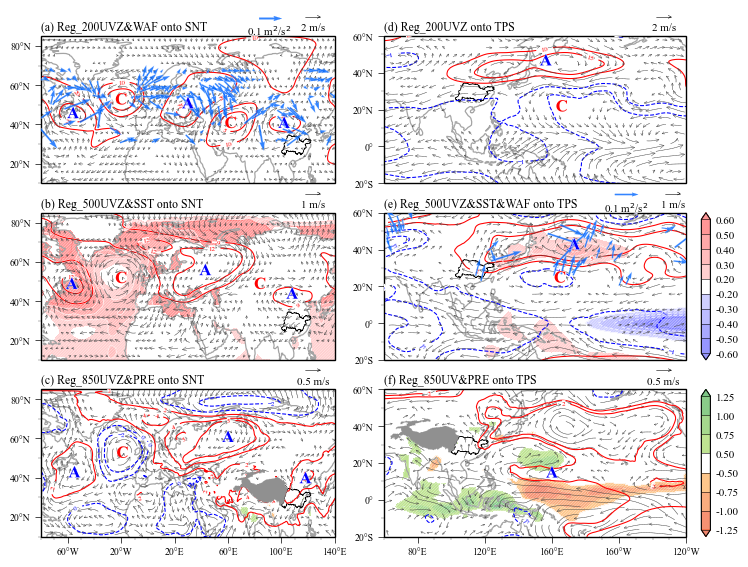

In [29]:
# 计算相关系数
corr_z_1 = np.zeros((len(Z['level']), len(Z['lat']), len(Z['lon'])))
corr_z_2 = np.zeros((len(Z['level']), len(Z['lat']), len(Z['lon'])))
reg_z_1 = np.zeros((len(Z['level']), len(Z['lat']), len(Z['lon'])))
reg_z_2 = np.zeros((len(Z['level']), len(Z['lat']), len(Z['lon'])))

corr_u_1 = np.zeros((len(U['level']), len(U['lat']), len(U['lon'])))
corr_u_2 = np.zeros((len(U['level']), len(U['lat']), len(U['lon'])))
reg_u_1 = np.zeros((len(U['level']), len(U['lat']), len(U['lon'])))
reg_u_2 = np.zeros((len(U['level']), len(U['lat']), len(U['lon'])))

corr_v_1 = np.zeros((len(V['level']), len(V['lat']), len(V['lon'])))
corr_v_2 = np.zeros((len(V['level']), len(V['lat']), len(V['lon'])))
reg_v_1 = np.zeros((len(V['level']), len(V['lat']), len(V['lon'])))
reg_v_2 = np.zeros((len(V['level']), len(V['lat']), len(V['lon'])))

corr_t_1 = np.zeros((len(T['level']), len(T['lat']), len(T['lon'])))
corr_t_2 = np.zeros((len(T['level']), len(T['lat']), len(T['lon'])))
reg_t_1 = np.zeros((len(T['level']), len(T['lat']), len(T['lon'])))
reg_t_2 = np.zeros((len(T['level']), len(T['lat']), len(T['lon'])))

corr_pre_1 = np.zeros((len(Pre['lat']), len(Pre['lon'])))
corr_pre_2 = np.zeros((len(Pre['lat']), len(Pre['lon'])))
reg_pre_1 = np.zeros((len(Pre['lat']), len(Pre['lon'])))
reg_pre_2 = np.zeros((len(Pre['lat']), len(Pre['lon'])))

corr_sst_1 = np.zeros((len(Sst['lat']), len(Sst['lon'])))
corr_sst_2 = np.zeros((len(Sst['lat']), len(Sst['lon'])))
reg_sst_1 = np.zeros((len(Sst['lat']), len(Sst['lon'])))
reg_sst_2 = np.zeros((len(Sst['lat']), len(Sst['lon'])))

corr_radio_1 = np.zeros((len(surface_radio['lat']), len(surface_radio['lon'])))
corr_radio_2 = np.zeros((len(surface_radio['lat']), len(surface_radio['lon'])))
reg_radio_1 = np.zeros((len(surface_radio['lat']), len(surface_radio['lon'])))
reg_radio_2 = np.zeros((len(surface_radio['lat']), len(surface_radio['lon'])))

## 全区一致型
K_series = K_type.sel(type=2)['K'].data
K_series = K_series[:-1]
K_series = (K_series - np.mean(K_series))/np.std(K_series)
# ### 印度洋降水
# zone = [53, 83, 10, -10]
# corr_NPW = regress(K_series, Pre['pre'].sel(lon=slice(zone[0], zone[1]), lat=slice(zone[2], zone[3]), year=slice(1961, 2021)).data)[0]
# time_series = ((Pre.sel(lon=slice(zone[0], zone[1]), lat=slice(zone[2], zone[3]), year=slice(1961, 2021))
#                 - Pre.sel(lon=slice(zone[0], zone[1]), lat=slice(zone[2], zone[3]), year=slice(1961, 2021)).mean(['year']))*corr_NPW).mean(['lat', 'lon'])['pre'].to_numpy()
#### 北大西洋暖
zone = [-75, -10, 50, 25]
Sst = lonlat_trs(Sst, type='360->180')
Pre = lonlat_trs(Pre, type='360->180')
corr_NPW = regress(K_series, Sst['sst'].sel(lon=slice(zone[0], zone[1]), lat=slice(zone[2], zone[3]), year=slice(1961, 2021)).data)[0]
# corr_NPW = np.where(corr_NPW > 0, corr_NPW, 0)
sst_ano = Sst.sel(lon=slice(zone[0], zone[1]), lat=slice(zone[2], zone[3]), year=slice(1961, 2021)) - Sst.sel(lon=slice(zone[0], zone[1]), lat=slice(zone[2], zone[3]), year=slice(1961, 2021)).mean(['year'])
time_series = (sst_ano*corr_NPW).mean(['lat', 'lon'])['sst'].to_numpy()
# time_series = (Sst.sel(lon=slice(zone[0], zone[1]), lat=slice(zone[2], zone[3]), year=slice(1961, 2021))
#                 *corr_NPW).mean(['lat', 'lon'])['sst'].to_numpy()
Sst = lonlat_trs(Sst, type='180->360')
Pre = lonlat_trs(Pre, type='180->360')
time_series = (time_series - np.mean(time_series))/np.std(time_series)
zone_1 = zone
time_series_1 = (time_series - np.mean(time_series))/np.std(time_series)
draw_zone_1 = [-80, 140, 10, 85]
c_lon_1 = 0

#### 拉尼娜
zone = [120, 360-80, 10, -10]
# zone = [120, 175, 10, -10]
corr_LN = regress(K_series, Sst['sst'].sel(lon=slice(zone[0], zone[1]), lat=slice(zone[2], zone[3]), year=slice(1961, 2021)).data)[0]
sst_ano = Sst.sel(lon=slice(zone[0], zone[1]), lat=slice(zone[2], zone[3]), year=slice(1961, 2021)) - Sst.sel(lon=slice(zone[0], zone[1]), lat=slice(zone[2], zone[3]), year=slice(1961, 2021)).mean(['year'])
# sst_ano = (sst_ano - sst_ano.mean(['year'])) / sst_ano.std(['year'])
time_series = (sst_ano*corr_LN).mean(['lat', 'lon'])['sst'].to_numpy()
# zone = [360-200, 360-80, 20, -15] # 东太降水
# corr_LN = regress(K_series, Pre['pre'].sel(lon=slice(zone[0], zone[1]), lat=slice(zone[2], zone[3])).data)[0]
# time_series = ((Pre.sel(lon=slice(zone[0], zone[1]), lat=slice(zone[2], zone[3]))- Pre.sel(lon=slice(zone[0], zone[1]), lat=slice(zone[2], zone[3])).mean(['year']))*corr_LN).mean(['lat', 'lon'])['pre'].to_numpy()
time_series = (time_series - np.mean(time_series))/np.std(time_series)#
zone_2 = zone
time_series_2 = (time_series - np.mean(time_series))/np.std(time_series)
draw_zone_2 = [60, 360-130, -15, 60]
c_lon_2 = 180   #'''
np.save(f'{PYFILE}/p2/data/type2_In_pre.npy', time_series_1)
np.save(f'{PYFILE}/p2/data/type2_LN.npy', time_series_2)


# 字体为新罗马
plt.rcParams['font.family'] = 'Times New Roman'
plt.close('all')

# 全区一致性运行此模块
for j in tq.trange(len(Z['level'])):
    lev = Z['level'][j].data
    reg_z_1[j], corr_z_1[j] = regress(time_series_1, Z['z'].sel(level=lev, year=slice(1961, 2021)).data)
    reg_u_1[j], corr_u_1[j] = regress(time_series_1, U['u'].sel(level=lev, year=slice(1961, 2021)).data)
    reg_v_1[j], corr_v_1[j] = regress(time_series_1, V['v'].sel(level=lev, year=slice(1961, 2021)).data)
    reg_t_1[j], corr_t_1[j] = regress(time_series_1, T['t'].sel(level=lev, year=slice(1961, 2021)).data)
reg_pre_1, corr_pre_1 = regress(time_series_1, Pre['pre'].sel(year=slice(1961, 2021)).data)
reg_sst_1, corr_sst_1 = regress(time_series_1, Sst['sst'].sel(year=slice(1961, 2021)).data)
reg_radio_1, corr_radio_1 = regress(time_series_1, (surface_radio['sshf'].sel(year=slice(1961, 2021)).data + surface_radio['slhf'].sel(year=slice(1961, 2021)).data) / 86400)



for j in tq.trange(len(Z['level'])):
    lev = Z['level'][j].data
    reg_z_2[j], corr_z_2[j] = regress(time_series_2, Z['z'].sel(level=lev, year=slice(1961, 2021)).data)
    reg_u_2[j], corr_u_2[j] = regress(time_series_2, U['u'].sel(level=lev, year=slice(1961, 2021)).data)
    reg_v_2[j], corr_v_2[j] = regress(time_series_2, V['v'].sel(level=lev, year=slice(1961, 2021)).data)
    reg_t_2[j], corr_t_2[j] = regress(time_series_2, T['t'].sel(level=lev, year=slice(1961, 2021)).data)
reg_pre_2, corr_pre_2 = regress(time_series_2, Pre['pre'].sel(year=slice(1961, 2021)).data)
reg_sst_2, corr_sst_2 = regress(time_series_2, Sst['sst'].sel(year=slice(1961, 2021)).data)
reg_radio_2, corr_radio_2 = regress(time_series_2, (surface_radio['sshf'].sel(year=slice(1961, 2021)).data + surface_radio['slhf'].sel(year=slice(1961, 2021)).data) / 86400)

from climkit.significance_test import r_test

p_th = r_test(61, 0.1) # 62为样本量，0.1为显著性水平

# type2绘图
if 2:
    fig = plt.figure(figsize=(8.88*1.25*(26+28)/72, 5*1.3))
    fig.subplots_adjust(hspace=0.4)  # Increase vertical spacing between subplots
    xticks1 = np.array([-60, -20, 20, 60, 100, 140])
    yticks1 = np.array([20, 40, 60, 80])
    #子图间距
    gs = gridspec.GridSpec(3, 2, width_ratios=[25*7/10/36, 18/36], height_ratios=[1, 1, 1], hspace=0.2, wspace=0.165)
    ax4 = fig.add_subplot(gs[0, 0], projection=ccrs.PlateCarree(central_longitude=c_lon_1))
        # 统一加粗所有四个边框
    for spine in ax4.spines.values():
        spine.set_linewidth(1)  # 设置边框线宽
    ax4.set_title(f"(a) Reg_200UVZ&WAF onto SNT", fontsize=8.5, loc='left', y=0.98)
    ax4.set_extent(draw_zone_1, crs=ccrs.PlateCarree())
    ax4.set_aspect('auto')
    ax4.add_feature(cfeature.COASTLINE.with_scale('110m'), linewidth=0.9, color="#a4a4a4")
    # ax4.add_feature(cfeature.LAND.with_scale('110m'), color='lightgray', lw=0.05)
    ax4.add_geometries(Reader(fr'{PYFILE}/map/self/长江_TP/长江_tp.shp').geometries(), ccrs.PlateCarree(),
                      facecolor='none', edgecolor='black', linewidth=.5)
    # rec(ax4, zone_1, color='green')
    latlon_fmt(ax4, None, yticks1, MultipleLocator(45), MultipleLocator(10), MultipleLocator(30), MultipleLocator(10))
    # 3Dwaf
    Uc = xr.DataArray(U['u'].sel(level=[150, 200, 500]).mean('year').data,
                        coords=[('level', [150, 200, 500]),
                                ('lat', U['lat'].data),
                                ('lon', U['lon'].data)])
    Vc = xr.DataArray(V['v'].sel(level=[150, 200, 500]).mean('year').data,
                        coords=[('level', [150, 200, 500]),
                                ('lat', V['lat'].data),
                                ('lon', V['lon'].data)])
    Tc = xr.DataArray(T['t'].sel(level=[150, 200, 500]).mean('year').data,
                        coords=[('level', [150, 200, 500]),
                                ('lat', T['lat'].data),
                                ('lon', T['lon'].data)])
    GEOa = xr.DataArray(reg_z_1[1:4, :, :],
                        coords=[('level', [150, 200, 500]),
                                ('lat', U['lat'].data),
                                ('lon', U['lon'].data)])
    waf_x, waf_y, waf_z = TN_WAF_3D(Uc, Vc, GEOa, Tc)
    waf_x = lonlat_trs(waf_x, type='360->180')
    waf_y = lonlat_trs(waf_y, type='360->180')
    reg_z_, lon = add_cyclic_point(reg_z_1[2, :, :], coord=Z['lon'])
    corr_z_, lon = add_cyclic_point(corr_z_1[2, :, :], coord=Z['lon'])
    # # z
    z_high = ax4.contour(lon, Z['lat'], reg_z_/9.8, colors='red', levels=[20, 25], linewidths=0.77, transform=ccrs.PlateCarree(central_longitude=0))
    z_low = ax4.contour(lon, Z['lat'], reg_z_/9.8, colors='red', levels=[5, 10], linewidths=0.77, transform=ccrs.PlateCarree(central_longitude=0))
    clabel1 = z_high.clabel(inline=.5, fontsize=5)
    clabel2 = z_low.clabel(inline=.5, fontsize=5)
    clabels = clabel1 + clabel2
    for label in clabels:
        label.set_bbox(dict(facecolor='white',  # 背景色为白色
                            edgecolor='none',  # 无边框
                            pad=0,  # 标签与背景的间距
                            alpha=1,  # 背景的透明度 (0.8表示80%不透明)
                            zorder=20
                            ))
    # waf_contf_ = ax4.contourf(lon, Z['lat'], reg_z_/9.8,
    #                                        levels=np.array([-25, -20, -15, -10, -5, 5, 10, 15, 20, 25])*2,
    #                                        cmap=cmaps.temp_diff_18lev[2:-2], alpha=0.75,
    #                                        extend='both',
    #                                        transform=ccrs.PlateCarree(central_longitude=0))
    # waf_cont = ax4.contour(lon, Z['lat'], reg_z_/9.8, colors='white', levels=np.array([-25, -20, -15, -10, -5, 5, 10, 15, 20, 25])*2, linestyles='solid', linewidths=0.4, transform=ccrs.PlateCarree(central_longitude=0))
    p_test = np.where(np.abs(corr_z_) > p_th, 0, np.nan)

    # 显著性
    plt.rcParams['hatch.linewidth'] = 0.2
    plt.rcParams['hatch.color'] = '#FFFFFF'
    p_hatches = ax4.contourf(lon, Z['lat'], p_test, levels=[0, 1], hatches=['////////////', None], colors="none", add_colorbar=False, transform=ccrs.PlateCarree(central_longitude=0), edgecolor='none',  linewidths=0)

    # waf_contf = ax4.contourf(lon, Z['lat'], reg_z_/9.8,
    #                                        levels=np.array([-25, -20, -15, -10, -5, 5, 10, 15, 20, 25]),
    #                                        cmap=cmaps.temp_diff_18lev[2:-2], alpha=0.75,
    #                                        extend='both',
    #                                        transform=ccrs.PlateCarree(central_longitude=0))
    # waf_cont = ax4.contour(lon, Z['lat'], reg_z_/9.8, colors='white', levels=np.array([-25, -20, -15, -10, -5, 5, 10, 15, 20, 25]), linestyles='solid', linewidths=0.4, transform=ccrs.PlateCarree(central_longitude=0))
    # p_test = np.where(np.abs(corr_z_) > p_th, 0, np.nan)
    # #ax4.quiver(lon, Z['lat'], p_test, p_test, transform=ccrs.PlateCarree(central_longitude=0), color='w', scale=20, headlength=2, headaxislength=2, regrid_shape=60)
    # # 显著性
    # plt.rcParams['hatch.linewidth'] = 0.2
    # plt.rcParams['hatch.color'] = '#FFFFFF'
    # p_hatches = ax4.contourf(lon, Z['lat'], p_test, levels=[0, 1], hatches=['////////////', None], colors="none", add_colorbar=False, transform=ccrs.PlateCarree(central_longitude=0), edgecolor='none',  linewidths=0)
    wind = Curlyquiver(ax4, U['lon'], U['lat'], reg_u_1[2, :, :], reg_v_1[2, :, :], thinning=["15%", 'min'],
                                  center_lon=c_lon_1, arrowsize=.8, scale=6, linewidth=0.3, regrid=20,
                                   color='#454545', nanmax=20/3, MinDistance=[0.7, 0.1])
    wind.key(fig, U=2, label='2 m/s', ud=7.87, edgecolor='none', arrowsize=.5, linewidth=0.4,color='k', fontproperties={'size': 8})
    # WAF_cq = Curlyquiver(ax4, waf_x['lon'], waf_x['lat'][:180],
    #                               waf_x[1][:180, :], waf_y[1][:180, :], thinning=['50%', 'min'], alpha=0.5,
    #                               regrid=10, center_lon=c_lon_1, arrowsize=.8, scale=3, linewidth=1.,
    #                               color='purple', nanmax=.2, MinDistance=[0.8, 0.1], regrid_reso=2.5)
    # WAF_cq.key(fig, U=.03, label='0.03 m$^2$/s$^2$', lr=1.8, ud=7.7, edgecolor='none', arrowsize=.5, linewidth=0.4, fontproperties={'size': 8})
    waf_x_ = waf_x[1][40:120, :]
    waf_y_ = waf_y[1][40:120, :]
    waf_lat = waf_x['lat'][40:120]
    waf_lon = waf_x['lon']
    waf_mag = np.sqrt(waf_x_**2 + waf_y_**2)
    low = np.nanpercentile(waf_mag.values, 85)
    high = np.nanpercentile(waf_mag.values, 89)
    mask = (waf_mag > low) & (waf_mag <= high) & (waf_x_ >= 0)
    waf_x_masked = waf_x_.where(mask)
    waf_y_masked = waf_y_.where(mask)
    WAF_Q = ax4.quiver(
                        waf_lon,
                        waf_lat,
                        waf_x_masked,
                        waf_y_masked,
                        scale=1.3, linewidth=0.15, color='#0066ff', edgecolors='white', pivot='mid',
                        transform=ccrs.PlateCarree(central_longitude=0), alpha=0.8, width=.0075,
                        regrid_shape=8, zorder=40
                        )


    low = np.nanpercentile(waf_mag.values, 70)
    high = np.nanpercentile(waf_mag.values, 85)
    mask = (waf_mag > low) & (waf_mag <= high) & (waf_x_ >= 0)
    waf_x_masked = waf_x_.where(mask)
    waf_y_masked = waf_y_.where(mask)
    WAF_Q = ax4.quiver(
                        waf_lon,
                        waf_lat,
                        waf_x_masked,
                        waf_y_masked,
                        scale=1.3, linewidth=0.15, color='#0066ff', edgecolors='white', pivot='mid',
                        transform=ccrs.PlateCarree(central_longitude=0), alpha=0.8, width=.0065,
                        regrid_shape=14, zorder=40
                        )

    low = np.nanpercentile(waf_mag.values, 0)
    high = np.nanpercentile(waf_mag.values, 70)
    mask = (waf_mag > low) & (waf_mag <= high) & (waf_x_ >= 0)
    waf_x_masked = waf_x_.where(mask)
    waf_y_masked = waf_y_.where(mask)
    WAF_Q = ax4.quiver(
                        waf_lon,
                        waf_lat,
                        waf_x_masked,
                        waf_y_masked,
                        scale=1.3, linewidth=0.15, color='#0066ff', edgecolors='white', pivot='mid',
                        transform=ccrs.PlateCarree(central_longitude=0), alpha=0.8, width=.0055,
                        regrid_shape=18, zorder=40
                        )
    ax4.quiverkey(WAF_Q, X=0.778, Y=1.125, U=0.1, label='0.1 m$^2$/s$^2$', labelpos='S', coordinates='axes', color='#0066ff', labelcolor='black', fontproperties={'size': 8}, labelsep=0.06)
    # 边框显示为黑色
    ax4.grid(False)
    for spine in ax4.spines.values():
        spine.set_edgecolor('black')

    ax5 = fig.add_subplot(gs[1, 0], projection=ccrs.PlateCarree(central_longitude=c_lon_1))
        # 统一加粗所有四个边框
    for spine in ax5.spines.values():
        spine.set_linewidth(1)  # 设置边框线宽
    ax5.set_title(f"(b) Reg_500UVZ&SST onto SNT", fontsize=8.5, loc='left', y=0.98)
    ax5.set_extent(draw_zone_1, crs=ccrs.PlateCarree())
    ax5.set_aspect('auto')
    # ax5.add_feature(cfeature.LAND.with_scale('110m'), color='lightgray', lw=0.05)
    ax5.add_feature(cfeature.COASTLINE.with_scale('110m'), linewidth=0.9, color="#a4a4a4")
    ax5.add_geometries(Reader(fr'{PYFILE}/map/self/长江_TP/长江_tp.shp').geometries(), ccrs.PlateCarree(),facecolor='none', edgecolor='black', linewidth=.5)
    # rec(ax5, zone_1, color='green')
    latlon_fmt(ax5, None, yticks1, MultipleLocator(45), MultipleLocator(10), MultipleLocator(30), MultipleLocator(10))
    # z
    reg_z_, lon = add_cyclic_point(reg_z_1[3, :, :], coord=Z['lon'])
    corr_z_, lon = add_cyclic_point(corr_z_1[3, :, :], coord=Z['lon'])
    ax5.contour(lon, Z['lat'], reg_z_/9.8, colors='#ffffff', levels=[9, 12], linewidths=1.2, transform=ccrs.PlateCarree(central_longitude=0)) # 红色描边
    z_high = ax5.contour(lon, Z['lat'], reg_z_/9.8, colors='red', levels=[9, 12], linewidths=0.77, transform=ccrs.PlateCarree(central_longitude=0))
    # z_low = ax5.contour(lon, Z['lat'], reg_z_/9.8, colors='blue', levels=[0, 5], linewidths=0.77, transform=ccrs.PlateCarree(central_longitude=0), linestyles='--')
    clabel1 = z_high.clabel(inline=.5, fontsize=5)
    # clabel2 = z_low.clabel(inline=.5, fontsize=5)
    clabels = clabel1 + clabel2
    for label in clabels:
        label.set_bbox(dict(facecolor='white',  # 背景色为白色
                            edgecolor='none',  # 无边框
                            pad=0,  # 标签与背景的间距
                            alpha=1,  # 背景的透明度 (0.8表示80%不透明)
                            zorder=20
                            ))

    reg_sst_, lon = add_cyclic_point(reg_sst_1[:, :], coord=Sst['lon'])
    corr_sst_, lon = add_cyclic_point(corr_sst_1[:, :], coord=Sst['lon'])
    # sst
    sst = ax5.contourf(lon, Sst['lat'], reg_sst_, cmap=cmaps.GMT_polar[4:10] + cmaps.CBR_wet[0] + cmaps.GMT_polar[10:-4], levels=[-.6, -.5, -.4, -.3, -.2, .2, .3, .4, .5, .6], extend='both', alpha=0.75, transform=ccrs.PlateCarree(central_longitude=0))
    ax5.contour(lon, Sst['lat'], reg_sst_, colors='white', levels=[-.5, -.4, -.3, .3, .4, .5], linewidths=0.75, transform=ccrs.PlateCarree(central_longitude=0), alpha=0.75)
    p_test = np.where(np.abs(corr_sst_) > p_th, 0, np.nan)
    # 显著性
    p_hatches = ax5.contourf(lon, Sst['lat'], p_test, levels=[0, 1], hatches=['////////////', None], colors="none", add_colorbar=False, transform=ccrs.PlateCarree(central_longitude=0), edgecolor='none',  linewidths=0)
    plt.rcParams['hatch.linewidth'] = 0.2
    plt.rcParams['hatch.color'] = '#FFFFFF'
    # Radio
    # reg_radio_, lon = add_cyclic_point(reg_radio_1[:, :], coord=surface_radio['lon'])##########################
    # corr_radio_, lon = add_cyclic_point(corr_radio_1[:, :], coord=surface_radio['lon'])##########################
    # surf_con = ax5.contourf(lon, surface_radio['lat'], reg_radio_, cmap=cmaps.MPL_PiYG_r[15:64-10] + cmaps.CBR_wet[0] + cmaps.MPL_PiYG_r[-64+10:-15], levels=np.array([-8, -6, -4, -2, -1, 1, 2, 4, 6, 8]), extend='both', alpha=0.75, transform=ccrs.PlateCarree(central_longitude=0), edgecolor='none')
    # p_test = np.where(np.abs(corr_radio_) > p_th, 0, np.nan)
    #ax5.quiver(lon, Sst['lat'], p_test, p_test, transform=ccrs.PlateCarree(central_longitude=0), color='w', scale=20, headlength=2, headaxislength=2, regrid_shape=60)
    # # 显著性
    # plt.rcParams['hatch.linewidth'] = 0.2
    # plt.rcParams['hatch.color'] = '#FFFFFF'
    # p_hatches = ax5.contourf(lon, surface_radio['lat'], p_test, levels=[0, 1], hatches=['////////////', None], colors="none", add_colorbar=False, transform=ccrs.PlateCarree(central_longitude=0), edgecolor='none',  linewidths=0)
    # wind
    wind = Curlyquiver(ax5, U['lon'], U['lat'], reg_u_1[3, :, :], reg_v_1[3, :, :], thinning=["15%", 'min'],
                                  center_lon=c_lon_1, arrowsize=.8, scale=3, linewidth=0.3, regrid=20,
                                  color='#454545', nanmax=wind.nanmax, MinDistance=[0.7, 0.1])
    wind.key(fig, U=1, label='1 m/s', ud=7.87, edgecolor='none', arrowsize=.5, color='k', linewidth=0.4, fontproperties={'size': 8})
    # 边框显示为黑色
    ax5.grid(False)
    for spine in ax5.spines.values():
        spine.set_edgecolor('black')

    ax6 = fig.add_subplot(gs[2, 0], projection=ccrs.PlateCarree(central_longitude=c_lon_1))
        # 统一加粗所有四个边框
    for spine in ax6.spines.values():
        spine.set_linewidth(1)  # 设置边框线宽
    ax6.set_title(f"(c) Reg_850UVZ&PRE onto SNT", fontsize=8.5, loc='left', y=0.98)
    ax6.set_extent(draw_zone_1, crs=ccrs.PlateCarree())
    ax6.set_aspect('auto')
    # ax6.add_feature(cfeature.LAND.with_scale('110m'), color='lightgray', lw=0.05)
    ax6.add_feature(cfeature.COASTLINE.with_scale('110m'), linewidth=0.9, color="#a4a4a4")
    ax6.add_geometries(Reader(f'{PYFILE}/map/self/长江_TP/长江_tp.shp').geometries(), ccrs.PlateCarree(),facecolor='none', edgecolor='black', linewidth=.5)
    # rec(ax6, zone_1, color='green')
    ax6.add_geometries(Reader(f'{PYFILE}/map/地图边界数据/青藏高原边界数据总集/TPBoundary_2500m/TPBoundary_2500m.shp').geometries(),
                                   ccrs.PlateCarree(), facecolor='#909090', edgecolor='#909090', linewidth=.1, hatch='.', zorder=10)
    latlon_fmt(ax6, xticks1, yticks1, MultipleLocator(45), MultipleLocator(10), MultipleLocator(30), MultipleLocator(10))

    reg_pre_da = xr.DataArray(reg_pre_1, coords=[Pre['lat'], Pre['lon']], dims=['lat', 'lon'])
    reg_pre_da = reg_pre_da.interp(
        lat=np.arange(-90, 90, 0.25),
        lon=np.arange(0, 360, 0.25),
        method='linear',
        kwargs={'fill_value': "extrapolate"}
    )

    reg_pre_, reg_pre_da_lon = add_cyclic_point(reg_pre_da.values, coord=reg_pre_da['lon'])
    corr_pre_, lon = add_cyclic_point(corr_pre_1[:, :], coord=Pre['lon'])
    # reg_pre_ = np.where((np.abs(reg_pre_) < .5), np.nan, reg_pre_)
    # pre
    pre = ax6.contourf(reg_pre_da_lon, reg_pre_da['lat'], reg_pre_, cmap=cmaps.MPL_RdYlGn[22+0:56] + cmaps.CBR_wet[0] + cmaps.MPL_RdYlGn[72:106-0], alpha=0.75, levels=[-1.25, -1., -.75, -.5, .5, .75, 1., 1.25], extend='both', transform=ccrs.PlateCarree(central_longitude=0))
    pre_edge = ax6.contour(reg_pre_da_lon, reg_pre_da['lat'], reg_pre_, colors='white', levels=[-1.25, -1., -.75, -.5, .5, .75, 1., 1.25], linestyles='solid',linewidths=0.2, transform=ccrs.PlateCarree(central_longitude=0))
    p_test = np.where(np.abs(corr_pre_) > p_th, 0, np.nan)
    #ax6.quiver(lon, Pre['lat'], p_test, p_test, transform=ccrs.PlateCarree(central_longitude=0), color='w', scale=20, headlength=2, headaxislength=2, regrid_shape=60)
    # 显著性
    p_hatches = ax6.contourf(lon, Pre['lat'], p_test, levels=[0, 1], hatches=['////////////', None], colors="none", add_colorbar=False, transform=ccrs.PlateCarree(central_longitude=0), edgecolor='none',  linewidths=0)
    plt.rcParams['hatch.linewidth'] = 0.2
    plt.rcParams['hatch.color'] = '#FFFFFF'
    # wind
    wind = Curlyquiver(ax6, U['lon'], U['lat'], reg_u_1[4, :, :], reg_v_1[4, :, :], thinning=["15%", 'min'],
                                  center_lon=c_lon_1, arrowsize=.8, scale=3/2, linewidth=0.3, regrid=20,
                                color='#454545', nanmax=wind.nanmax, MinDistance=[0.7, 0.1])
    wind.key(fig, U=.5, label='0.5 m/s', ud=7.87, edgecolor='none', arrowsize=.5, color='k', linewidth=0.4, fontproperties={'size': 8})
    # z
    reg_z_, lon = add_cyclic_point(reg_z_1[4, :, :], coord=Z['lon'])
    corr_z_, lon = add_cyclic_point(corr_z_1[4, :, :], coord=Z['lon'])
    z_high = ax6.contour(lon, Z['lat'], reg_z_/9.8, colors='red', levels=[2, 4, 5], linewidths=0.77, transform=ccrs.PlateCarree(central_longitude=0))
    z_low = ax6.contour(lon, Z['lat'], reg_z_/9.8, colors='blue', levels=[-2, 0], linewidths=0.77, transform=ccrs.PlateCarree(central_longitude=0), linestyles='--')
    clabel1 = z_high.clabel(inline=.5, fontsize=5)
    clabel2 = z_low.clabel(inline=.5, fontsize=5)
    clabels = clabel1 + clabel2
    for label in clabels:
        label.set_bbox(dict(facecolor='white',  # 背景色为白色
                            edgecolor='none',  # 无边框
                            pad=0,  # 标签与背景的间距
                            alpha=1,  # 背景的透明度 (0.8表示80%不透明)
                            zorder=20
                            ))
    # 边框显示为黑色
    ax6.grid(False)
    for spine in ax6.spines.values():
        spine.set_edgecolor('black')

    ################################################################右图
    xticks1 = np.array([80, 120, 160, 200, 240])
    yticks1 = np.array([-20, 0, 20, 40, 60])
    ax1 = fig.add_subplot(gs[0, 1], projection=ccrs.PlateCarree(central_longitude=c_lon_2))
        # 统一加粗所有四个边框
    for spine in ax1.spines.values():
        spine.set_linewidth(1)  # 设置边框线宽
    ax1.set_title(f"(d) Reg_200UVZ onto TPS", fontsize=8.5, loc='left', y=0.98)
    ax1.set_extent(draw_zone_2, crs=ccrs.PlateCarree())
    ax1.set_aspect('auto')
    # ax1.add_feature(cfeature.LAND.with_scale('110m'), color='lightgray', lw=0.05)
    ax1.add_feature(cfeature.COASTLINE.with_scale('110m'), linewidth=0.9, color="#a4a4a4")
    ax1.add_geometries(Reader(f'{PYFILE}/map/self/长江_TP/长江_tp.shp').geometries(), ccrs.PlateCarree(),
                      facecolor='none', edgecolor='black', linewidth=.5)
    # rec(ax1, zone_2, color='green')
    latlon_fmt(ax1, None, yticks1, MultipleLocator(45), MultipleLocator(10), MultipleLocator(30), MultipleLocator(10))
    # 3Dwaf
    Uc = xr.DataArray(U['u'].sel(level=[150, 200, 500]).mean('year').data,
                        coords=[('level', [150, 200, 500]),
                                ('lat', U['lat'].data),
                                ('lon', U['lon'].data)])
    Vc = xr.DataArray(V['v'].sel(level=[150, 200, 500]).mean('year').data,
                        coords=[('level', [150, 200, 500]),
                                ('lat', V['lat'].data),
                                ('lon', V['lon'].data)])
    Tc = xr.DataArray(T['t'].sel(level=[150, 200, 500]).mean('year').data,
                        coords=[('level', [150, 200, 500]),
                                ('lat', T['lat'].data),
                                ('lon', T['lon'].data)])
    GEOa = xr.DataArray(reg_z_2[1:4, :, :],
                        coords=[('level', [150, 200, 500]),
                                ('lat', U['lat'].data),
                                ('lon', U['lon'].data)])
    waf_x, waf_y, waf_z = TN_WAF_3D(Uc, Vc, GEOa, Tc)
    waf_x = lonlat_trs(waf_x, type='360->180')
    waf_y = lonlat_trs(waf_y, type='360->180')
    reg_z_, lon = add_cyclic_point(reg_z_2[2, :, :], coord=Z['lon'])
    corr_z_, lon = add_cyclic_point(corr_z_2[2, :, :], coord=Z['lon'])
    z_high = ax1.contour(lon, Z['lat'], reg_z_/9.8, colors='red', levels=[10, 15], linewidths=0.77, transform=ccrs.PlateCarree(central_longitude=0))
    z_low = ax1.contour(lon, Z['lat'], reg_z_/9.8, colors='blue', levels=[-5, -1], linewidths=0.77, transform=ccrs.PlateCarree(central_longitude=0), linestyles='--')
    clabel1 = z_high.clabel(inline=.5, fontsize=5)
    clabel2 = z_low.clabel(inline=.5, fontsize=5)
    clabels = clabel1 + clabel2
    for label in clabels:
        label.set_bbox(dict(facecolor='white',  # 背景色为白色
                            edgecolor='none',  # 无边框
                            pad=0,  # 标签与背景的间距
                            alpha=1,  # 背景的透明度 (0.8表示80%不透明)
                            zorder=20
                            ))
    # waf_contf = ax1.contourf(lon, Z['lat'], reg_z_/9.8,
    #                                        levels=np.array([-25, -20, -15, -10, -5, 5, 10, 15, 20, 25]),
    #                                        cmap=cmaps.temp_diff_18lev[2:-2], alpha=0.75,
    #                                        extend='both',
    #                                        transform=ccrs.PlateCarree(central_longitude=0))
    # waf_cont = ax1.contour(lon, Z['lat'], reg_z_/9.8, colors='white', levels=np.array([-25, -20, -15, -10, -5, 5, 10, 15, 20, 25]), linestyles='solid', linewidths=0.4, transform=ccrs.PlateCarree(central_longitude=0))
    p_test = np.where(np.abs(corr_z_) > p_th, 0, np.nan)
    #ax1.quiver(lon, Z['lat'], p_test, p_test, transform=ccrs.PlateCarree(central_longitude=0), color='w', scale=20, headlength=2, headaxislength=2, regrid_shape=60)
    # 显著性
    p_hatches = ax1.contourf(lon, Z['lat'], p_test, levels=[0, 1], hatches=['////////////', None], colors="none", add_colorbar=False, transform=ccrs.PlateCarree(central_longitude=0), edgecolor='none',  linewidths=0)
    plt.rcParams['hatch.linewidth'] = 0.2
    plt.rcParams['hatch.color'] = '#FFFFFF'

    wind = Curlyquiver(ax1, U['lon'], U['lat'], reg_u_2[2, :, :], reg_v_2[2, :, :], thinning=["15%", 'min'],
                                  center_lon=c_lon_2, arrowsize=.8, scale=6, linewidth=0.3, regrid=20,
                                   color='#454545', nanmax=wind.nanmax, MinDistance=[0.7, 0.1])
    wind.key(fig, U=2, label='2 m/s', ud=7.87, edgecolor='none', arrowsize=.5, color='k', linewidth=0.4, fontproperties={'size': 8})
    # 边框显示为黑色
    ax1.grid(False)
    for spine in ax1.spines.values():
        spine.set_edgecolor('black')
    # # 色标
    # ax1_colorbar = inset_axes(ax1, width="3%", height="100%", loc='lower left', bbox_to_anchor=(1.12, 0., 1, 1), bbox_transform=ax1.transAxes, borderpad=0)
    # cb1 = plt.colorbar(waf_contf, cax=ax1_colorbar, orientation='vertical', drawedges=True)
    # cb1.outline.set_edgecolor('black')  # 将colorbar边框调为黑色
    # cb1.dividers.set_color('black') # 将colorbar内间隔线调为黑色
    # cb1.locator = ticker.FixedLocator(np.array([-25, -20, -15, -10, -5, 5, 10, 15, 20, 25]))
    # cb1.set_ticklabels(['-25', '-20', '-15', '-10', '-5', '5', '10', '15', '20', '25'])
    # cb1.ax.yaxis.set_ticks_position('right')
    # cb1.ax.yaxis.set_label_position('right')
    # # cb1.ax.set_ylabel('Right\npic', rotation=0, loc='bottom', fontsize=6)
    # cb1.ax.tick_params(length=0, labelsize=8)  # length为刻度线的长度
    #
    #     # 色标
    # ax4_colorbar = inset_axes(ax4, width="3%", height="100%", loc='lower left', bbox_to_anchor=(1.12, 0., 1, 1), bbox_transform=ax1.transAxes, borderpad=0)
    # cb4 = plt.colorbar(waf_contf_, cax=ax4_colorbar, orientation='vertical', drawedges=True)
    # cb4.outline.set_edgecolor('black')  # 将colorbar边框调为黑色
    # cb4.dividers.set_color('black') # 将colorbar内间隔线调为黑色
    # cb4.locator = ticker.FixedLocator(np.array([-50, -40, -30, -20, -10, 10, 20, 30, 40, 50]))
    # cb4.set_ticklabels(['-50', '-40', '-30', '-20', '-10', '10', '20', '30', '40', '50'])
    # cb4.ax.yaxis.set_ticks_position('left')
    # cb4.ax.yaxis.set_label_position('left')
    # # cb4.ax.set_ylabel('Left\npic', rotation=0, loc='bottom', fontsize=6)
    # cb4.ax.tick_params(length=0, labelsize=8)  # length为刻度线的长度

    ax2 = fig.add_subplot(gs[1, 1], projection=ccrs.PlateCarree(central_longitude=c_lon_2))
        # 统一加粗所有四个边框
    for spine in ax2.spines.values():
        spine.set_linewidth(1)  # 设置边框线宽
    ax2.set_title(f"(e) Reg_500UVZ&SST&WAF onto TPS", fontsize=8.5, loc='left', y=0.98)
    ax2.set_extent(draw_zone_2, crs=ccrs.PlateCarree())
    ax2.set_aspect('auto')
    # ax2.add_feature(cfeature.LAND.with_scale('110m'), color='lightgray', lw=0.05)
    ax2.add_feature(cfeature.COASTLINE.with_scale('110m'), linewidth=0.9, color="#a4a4a4")
    ax2.add_geometries(Reader(f'{PYFILE}/map/self/长江_TP/长江_tp.shp').geometries(), ccrs.PlateCarree(),facecolor='none', edgecolor='black', linewidth=.5)
    # rec(ax2, zone_2, color='green')
    latlon_fmt(ax2, None, yticks1, MultipleLocator(45), MultipleLocator(10), MultipleLocator(30), MultipleLocator(10))
    # z
    reg_z_, lon = add_cyclic_point(reg_z_2[3, :, :], coord=Z['lon'])
    corr_z_, lon = add_cyclic_point(corr_z_2[3, :, :], coord=Z['lon'])
    z_high = ax2.contour(lon, Z['lat'], reg_z_/9.8, colors='red', levels=[2, 5], linewidths=0.77, transform=ccrs.PlateCarree(central_longitude=0))
    z_low = ax2.contour(lon, Z['lat'], reg_z_/9.8, colors='blue', levels=[-3, -1], linewidths=0.77, transform=ccrs.PlateCarree(central_longitude=0), linestyles='--')
    clabel1 = z_high.clabel(inline=.5, fontsize=5)
    clabel2 = z_low.clabel(inline=.5, fontsize=5)
    clabels = clabel1 + clabel2
    for label in clabels:
        label.set_bbox(dict(facecolor='white',  # 背景色为白色
                            edgecolor='none',  # 无边框
                            pad=0,  # 标签与背景的间距
                            alpha=1,  # 背景的透明度 (0.8表示80%不透明)
                            zorder=20
                            ))
    reg_sst_, lon = add_cyclic_point(reg_sst_2[:, :], coord=Sst['lon'])
    corr_sst_, lon = add_cyclic_point(corr_sst_2[:, :], coord=Sst['lon'])
    # reg_sst_ = np.where((np.abs(reg_sst_) < .15) | np.isnan(reg_sst_), np.nan, reg_sst_)
    # sst
    sst = ax2.contourf(lon, Sst['lat'], reg_sst_, cmap=cmaps.GMT_polar[4:10] + cmaps.CBR_wet[0] + cmaps.GMT_polar[10:-4], levels=[-.6, -.5, -.4, -.3, -.2, .2, .3, .4, .5, .6], extend='both', alpha=0.75, transform=ccrs.PlateCarree(central_longitude=0))
    p_test = np.where(np.abs(corr_sst_) > p_th, 0, np.nan)
    # 显著性
    p_hatches = ax2.contourf(lon, Sst['lat'], p_test, levels=[0, 1], hatches=['////////////', None], colors="none", add_colorbar=False, transform=ccrs.PlateCarree(central_longitude=0), edgecolor='none',  linewidths=0)
    plt.rcParams['hatch.linewidth'] = 0.2
    plt.rcParams['hatch.color'] = '#FFFFFF'
    # wind
    wind = Curlyquiver(ax2, U['lon'], U['lat'], reg_u_2[3, :, :], reg_v_2[3, :, :], thinning=["15%", 'min'],
                                  center_lon=c_lon_2, arrowsize=.8, scale=3, linewidth=0.3, regrid=20,
                                  color='#454545', nanmax=wind.nanmax, MinDistance=[0.7, 0.1])
    wind.key(fig, U=1, label='1 m/s', lr=0.8, ud=7.87, edgecolor='none', arrowsize=.5, color='k', linewidth=0.4, fontproperties={'size': 8})
    # WAF_cq = Curlyquiver(ax2, waf_x['lon'], waf_x['lat'][:180], waf_x[2][:180, :], waf_y[2][:180, :],
    #                      thinning=['75%', 'min'],  alpha=0.5,
    #                      regrid=10, center_lon=c_lon_2, arrowsize=.8, scale=3, linewidth=1., color='purple', nanmax=.2, MinDistance=[0.8, 0.1], regrid_reso=2.5)
    # WAF_cq.key(fig, U=.03, label='0.03 m$^2$/s$^2$', lr=1.8, ud=7.87, edgecolor='none', arrowsize=.5, linewidth=0.4, fontproperties={'size': 8})
    waf_x_ = waf_x[2][:180, :]
    waf_y_ = waf_y[2][:180, :]
    waf_lat = waf_x['lat'][:180]
    waf_lon = waf_x['lon']
    waf_mag = np.sqrt(waf_x_**2 + waf_y_**2)
    low = np.nanpercentile(waf_mag.values, 94)
    high = np.nanpercentile(waf_mag.values, 99)
    mask = (waf_mag > low) & (waf_mag <= high) & (waf_x_ >= 0)
    waf_x_masked = waf_x_.where(mask)
    waf_y_masked = waf_y_.where(mask)
    WAF_Q = ax2.quiver(
                        waf_lon,
                        waf_lat,
                        waf_x_masked,
                        waf_y_masked,
                        scale=1.3, linewidth=0.15, color='#0066ff', edgecolors='white', pivot='mid',
                        transform=ccrs.PlateCarree(central_longitude=0), alpha=0.8, width=.006,
                        regrid_shape=18, zorder=40
                        )

    low = np.nanpercentile(waf_mag.values, 85)
    high = np.nanpercentile(waf_mag.values, 94)
    mask = (waf_mag > low) & (waf_mag <= high) & (waf_x_ >= 0)
    waf_x_masked = waf_x_.where(mask)
    waf_y_masked = waf_y_.where(mask)
    WAF_Q = ax2.quiver(
                        waf_lon,
                        waf_lat,
                        waf_x_masked,
                        waf_y_masked,
                        scale=1.3, linewidth=0.15, color='#0066ff', edgecolors='white', pivot='mid',
                        transform=ccrs.PlateCarree(central_longitude=0), alpha=0.8, width=.005,
                        regrid_shape=28, zorder=40
                        )

    low = np.nanpercentile(waf_mag.values, 80)
    high = np.nanpercentile(waf_mag.values, 85)
    mask = (waf_mag > low) & (waf_mag <= high) & (waf_x_ >= 0)
    waf_x_masked = waf_x_.where(mask)
    waf_y_masked = waf_y_.where(mask)
    WAF_Q = ax2.quiver(
                        waf_lon,
                        waf_lat,
                        waf_x_masked,
                        waf_y_masked,
                        scale=1.3, linewidth=0.15, color='#0066ff', edgecolors='white', pivot='mid',
                        transform=ccrs.PlateCarree(central_longitude=0), alpha=0.8, width=.004,
                        regrid_shape=38, zorder=40
                        )
    ax2.quiverkey(WAF_Q, X=0.80, Y=1.125, U=0.1, label='0.1 m$^2$/s$^2$', labelpos='S', coordinates='axes', color='#0066ff', labelcolor='black', fontproperties={'size': 8}, labelsep=0.06)

    # 边框显示为黑色
    ax2.grid(False)
    for spine in ax2.spines.values():
        spine.set_edgecolor('black')
    # 色条
    ax2_colorbar = inset_axes(ax2, width="3%", height="100%", loc='lower left', bbox_to_anchor=(1.05, 0., 1, 1), bbox_transform=ax2.transAxes, borderpad=0)
    cb2 = plt.colorbar(sst, cax=ax2_colorbar, orientation='vertical', drawedges=True)
    cb2.locator = ticker.FixedLocator(np.array([-.6, -.5, -.4, -.3, -.2, .2, .3, .4, .5, .6]))
    cb2.set_ticklabels([str(f'{i:.2f}') for i in [-.6, -.5, -.4, -.3, -.2, .2, .3, .4, .5, .6]])
    # cb2.set_ticklabels(['-0.5', '-0.4', '-0.3', '-0.2', '-0.15', '0.15', '0.2', '0.3', '0.4', '0.5'])
    cb2.outline.set_edgecolor('black')  # 将colorbar边框调为黑色
    cb2.dividers.set_color('black') # 将colorbar内间隔线调为黑色
    cb2.ax.tick_params(length=0, labelsize=8)  # length为刻度线的长度

    # # 色条
    # ax5_colorbar = inset_axes(ax5, width="3%", height="100%", loc='lower left', bbox_to_anchor=(1.05, 0., 1, 1), bbox_transform=ax2.transAxes, borderpad=0)
    # cb5 = plt.colorbar(surf_con, cax=ax5_colorbar, orientation='vertical', drawedges=True)
    # cb5.locator = ticker.FixedLocator(np.array([-8, -6, -4, -2, -1, 1, 2, 4, 6, 8]))
    # cb5.set_ticklabels(['-8', '-6', '-4', '-2', '-1', '1', '2', '4', '6', '8'])
    # cb5.outline.set_edgecolor('black')  # 将colorbar边框调为黑色
    # cb5.dividers.set_color('black') # 将colorbar内间隔线调为黑色
    # cb5.ax.tick_params(length=0, labelsize=8)  # length为刻度线的长度

    ax3 = fig.add_subplot(gs[2, 1], projection=ccrs.PlateCarree(central_longitude=c_lon_2))
        # 统一加粗所有四个边框
    for spine in ax3.spines.values():
        spine.set_linewidth(1)  # 设置边框线宽
    ax3.set_title(f"(f) Reg_850UV&PRE onto TPS", fontsize=8.5, loc='left', y=0.98)
    ax3.set_extent(draw_zone_2, crs=ccrs.PlateCarree())
    ax3.set_aspect('auto')
    # ax3.add_feature(cfeature.LAND.with_scale('110m'), color='lightgray', lw=0.05)
    ax3.add_feature(cfeature.COASTLINE.with_scale('110m'), linewidth=0.9, color="#a4a4a4")
    ax3.add_geometries(Reader(f'{PYFILE}/map/self/长江_TP/长江_tp.shp').geometries(), ccrs.PlateCarree(),facecolor='none', edgecolor='black', linewidth=.5)
    # rec(ax3, zone_2, color='green')
    ax3.add_geometries(Reader(f'{PYFILE}/map/地图边界数据/青藏高原边界数据总集/TPBoundary_2500m/TPBoundary_2500m.shp').geometries(),
                                   ccrs.PlateCarree(), facecolor='#909090', edgecolor='#909090', linewidth=.1, hatch='.', zorder=10)
    latlon_fmt(ax3, xticks1, yticks1, MultipleLocator(45), MultipleLocator(10), MultipleLocator(30), MultipleLocator(10))

    reg_pre_da = xr.DataArray(reg_pre_2, coords=[Pre['lat'], Pre['lon']], dims=['lat', 'lon'])
    reg_pre_da = reg_pre_da.interp(
        lat=np.arange(-90, 90, 0.25),
        lon=np.arange(0, 360, 0.25),
        method='linear',
        kwargs={'fill_value': "extrapolate"}
    )

    reg_pre_, reg_pre_da_lon = add_cyclic_point(reg_pre_da.values, coord=reg_pre_da['lon'])
    corr_pre_, lon = add_cyclic_point(corr_pre_2[:, :], coord=Pre['lon'])
    # reg_pre_ = np.where((np.abs(reg_pre_) < .5), np.nan, reg_pre_)
    # pre
    pre = ax3.contourf(reg_pre_da_lon, reg_pre_da['lat'], reg_pre_, cmap=cmaps.MPL_RdYlGn[22+0:56] + cmaps.CBR_wet[0] + cmaps.MPL_RdYlGn[72:106-0], alpha=0.75, levels=[-1.25, -1., -.75, -.5, .5, .75, 1., 1.25], extend='both', transform=ccrs.PlateCarree(central_longitude=0))
    pre_edge = ax3.contour(reg_pre_da_lon, reg_pre_da['lat'], reg_pre_, colors='white', levels=[-1.25, -1., -.75, -.5, .5, .75, 1., 1.25], linestyles='solid',linewidths=0.2, transform=ccrs.PlateCarree(central_longitude=0))
    p_test = np.where(np.abs(corr_pre_) > p_th, 0, np.nan)
    #ax3.quiver(lon, Pre['lat'], p_test, p_test, transform=ccrs.PlateCarree(central_longitude=0), color='w', scale=20, headlength=2, headaxislength=2, regrid_shape=60)
    # 显著性
    p_hatches = ax3.contourf(lon, Pre['lat'], p_test, levels=[0, 1], hatches=['////////////', None], colors="none", add_colorbar=False, transform=ccrs.PlateCarree(central_longitude=0), edgecolor='none',  linewidths=0)
    plt.rcParams['hatch.linewidth'] = 0.2
    plt.rcParams['hatch.color'] = '#FFFFFF'
    # wind
    wind = Curlyquiver(ax3, U['lon'], U['lat'], reg_u_2[4, :, :], reg_v_2[4, :, :], thinning=["15%", 'min'],
                                  center_lon=c_lon_2, arrowsize=.8, scale=3/2, linewidth=0.3, regrid=20,
                                color='#454545', nanmax=wind.nanmax, MinDistance=[0.7, 0.1])
    wind.key(fig, U=.5, label='0.5 m/s', ud=7.87, edgecolor='none', arrowsize=.5, color='k', linewidth=0.4, fontproperties={'size': 8})
    # z
    reg_z_, lon = add_cyclic_point(reg_z_2[4, :, :], coord=Z['lon'])
    corr_z_, lon = add_cyclic_point(corr_z_2[4, :, :], coord=Z['lon'])
    z_high = ax3.contour(lon, Z['lat'], reg_z_/9.8, colors='red', levels=[1, 2], linewidths=0.77, transform=ccrs.PlateCarree(central_longitude=0))
    z_low = ax3.contour(lon, Z['lat'], reg_z_/9.8, colors='blue', levels=[-5, -3], linewidths=0.77, transform=ccrs.PlateCarree(central_longitude=0), linestyles='--')
    clabel1 = z_high.clabel(inline=.5, fontsize=5)
    clabel2 = z_low.clabel(inline=.5, fontsize=5)
    clabels = clabel1 + clabel2
    for label in clabels:
        label.set_bbox(dict(facecolor='white',  # 背景色为白色
                            edgecolor='none',  # 无边框
                            pad=0,  # 标签与背景的间距
                            alpha=1,  # 背景的透明度 (0.8表示80%不透明)
                            zorder=20
                            ))
    # 边框显示为黑色
    ax3.grid(False)
    for spine in ax3.spines.values():
        spine.set_edgecolor('black')
    # 色条
    ax3_colorbar = inset_axes(ax3, width="3%", height="100%", loc='lower left', bbox_to_anchor=(1.05, 0., 1, 1), bbox_transform=ax3.transAxes, borderpad=0)
    cb3 = plt.colorbar(pre, cax=ax3_colorbar, orientation='vertical', drawedges=True)
    cb3.outline.set_edgecolor('black')  # 将colorbar边框调为黑色
    cb3.dividers.set_color('black') # 将colorbar内间隔线调为黑色
    cb3.locator = ticker.FixedLocator(np.array([-1.25, -1., -.75, -.5, .5, .75, 1., 1.25]))
    cb3.set_ticklabels([str(f'{i:.2f}') for i in [-1.25, -1., -.75, -.5, .5, .75, 1., 1.25]])
    # cb3.set_ticklabels(['-1.25', '-1', '-0.75', '-0.5', '0.5', '0.75', '1', '1.25'])
    cb3.ax.tick_params(length=0, labelsize=8)  # length为刻度线的长度


    plot_text(ax1, 160, 21, 'C', 12, 'red')
    plot_text(ax1, 151, 46, 'A', 12, 'blue')

    plot_text(ax2, 159, 24, 'C', 12, 'red')
    plot_text(ax2, 167, 42, 'A', 12, 'blue')

    plot_text(ax3, 160, 14, 'A', 12, 'blue')

    plot_text(ax4, -56, 45, 'A', 12, 'blue')
    plot_text(ax4, -20, 52, 'C', 12, 'red')
    plot_text(ax4,  30, 50, 'A', 12, 'blue')
    plot_text(ax4,  62, 40, 'C', 12, 'red')
    plot_text(ax4, 102, 40, 'A', 12, 'blue')

    plot_text(ax5, -57, 48, 'A', 12, 'blue')
    plot_text(ax5, -20, 51, 'C', 12, 'red')
    plot_text(ax5,  43, 55, 'A', 12, 'blue')
    plot_text(ax5,  84, 48, 'C', 12, 'red')
    plot_text(ax5, 108, 43, 'A', 12, 'blue')

    plot_text(ax6, -55, 42, 'A', 12, 'blue')
    plot_text(ax6, -19, 52, 'C', 12, 'red')
    plot_text(ax6,  60, 60, 'A', 12, 'blue')
    # plot_text(ax6, 100, 48, 'C', 8, 'red')
    plot_text(ax6, 118, 39, 'A', 12, 'blue')


    plt.savefig(f'{PYFILE}/p2/pic/回归场2.pdf', bbox_inches='tight')
    plt.savefig(f'{PYFILE}/p2/pic/回归场2.png', bbox_inches='tight', dpi=600)
    plt.show()


100%|██████████| 5/5 [00:00<00:00,  5.79it/s]
/opt/homebrew/Caskroom/miniconda/base/envs/PY312/lib/python3.12/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/Volumes/sty/code/work/Meteorological/climkit/Cquiver.py:296: UserWarning: 已将Y轴反转，因为Y轴坐标轴为非增长序列。
  warnings.warn('已将Y轴反转，因为Y轴坐标轴为非增长序列。', UserWarning)
路径积分: 100%|██████████| 1093/1093 [00:00<00:00, 5408.60points/s]
/opt/homebrew/Caskroom/miniconda/base/envs/PY312/lib/python3.12/site-packages/shapely/constructive.py:246: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/opt/homebrew/Caskroom/miniconda/base/envs/PY312/lib/python3.12/site-packages/shapely/set_operations.py:168: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
极速降重中: 100%|██████████| 874/874 [00:00<00:00, 50731.70lines/s]
/opt/homebrew/Caskroom/miniconda

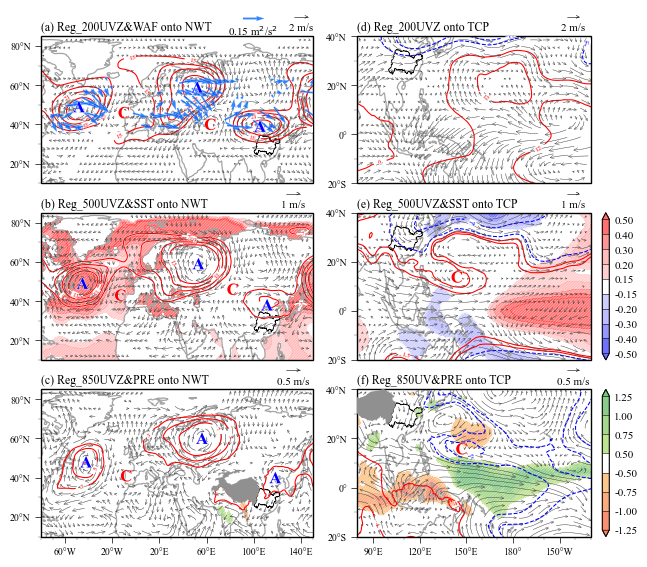

In [37]:
# 计算相关系数
corr_z_1 = np.zeros((len(Z['level']), len(Z['lat']), len(Z['lon'])))
corr_z_2 = np.zeros((len(Z['level']), len(Z['lat']), len(Z['lon'])))
reg_z_1 = np.zeros((len(Z['level']), len(Z['lat']), len(Z['lon'])))
reg_z_2 = np.zeros((len(Z['level']), len(Z['lat']), len(Z['lon'])))

corr_u_1 = np.zeros((len(U['level']), len(U['lat']), len(U['lon'])))
corr_u_2 = np.zeros((len(U['level']), len(U['lat']), len(U['lon'])))
reg_u_1 = np.zeros((len(U['level']), len(U['lat']), len(U['lon'])))
reg_u_2 = np.zeros((len(U['level']), len(U['lat']), len(U['lon'])))

corr_v_1 = np.zeros((len(V['level']), len(V['lat']), len(V['lon'])))
corr_v_2 = np.zeros((len(V['level']), len(V['lat']), len(V['lon'])))
reg_v_1 = np.zeros((len(V['level']), len(V['lat']), len(V['lon'])))
reg_v_2 = np.zeros((len(V['level']), len(V['lat']), len(V['lon'])))

corr_t_1 = np.zeros((len(T['level']), len(T['lat']), len(T['lon'])))
corr_t_2 = np.zeros((len(T['level']), len(T['lat']), len(T['lon'])))
reg_t_1 = np.zeros((len(T['level']), len(T['lat']), len(T['lon'])))
reg_t_2 = np.zeros((len(T['level']), len(T['lat']), len(T['lon'])))

corr_pre_1 = np.zeros((len(Pre['lat']), len(Pre['lon'])))
corr_pre_2 = np.zeros((len(Pre['lat']), len(Pre['lon'])))
reg_pre_1 = np.zeros((len(Pre['lat']), len(Pre['lon'])))
reg_pre_2 = np.zeros((len(Pre['lat']), len(Pre['lon'])))

corr_sst_1 = np.zeros((len(Sst['lat']), len(Sst['lon'])))
corr_sst_2 = np.zeros((len(Sst['lat']), len(Sst['lon'])))
reg_sst_1 = np.zeros((len(Sst['lat']), len(Sst['lon'])))
reg_sst_2 = np.zeros((len(Sst['lat']), len(Sst['lon'])))

corr_radio_1 = np.zeros((len(surface_radio['lat']), len(surface_radio['lon'])))
corr_radio_2 = np.zeros((len(surface_radio['lat']), len(surface_radio['lon'])))
reg_radio_1 = np.zeros((len(surface_radio['lat']), len(surface_radio['lon'])))
reg_radio_2 = np.zeros((len(surface_radio['lat']), len(surface_radio['lon'])))


## 西部型
K_series = K_type.sel(type=3)['K'].data
K_series = (K_series - np.mean(K_series))/np.std(K_series)
#### 北大西洋暖
Sst = lonlat_trs(Sst, type='360->180')
Pre = lonlat_trs(Pre, type='360->180')
zone = [-70, -20, 55, 35]
corr_NPW = regress(K_series, Sst['sst'].sel(lon=slice(zone[0], zone[1]), lat=slice(zone[2], zone[3])).data)[0]
time_series = ((Sst.sel(lon=slice(zone[0], zone[1]), lat=slice(zone[2], zone[3]))- Sst.sel(lon=slice(zone[0], zone[1]), lat=slice(zone[2], zone[3])).mean(['year']))*corr_NPW).mean(['lat', 'lon'])['sst'].to_numpy()
# zone = [-50, 10, 15, -10] # 大西洋干旱
# corr_LN = regress(K_series, Pre['pre'].sel(lon=slice(zone[0], zone[1]), lat=slice(zone[2], zone[3])).data)[0]
# time_series = ((Pre.sel(lon=slice(zone[0], zone[1]), lat=slice(zone[2], zone[3]))- Pre.sel(lon=slice(zone[0], zone[1]), lat=slice(zone[2], zone[3])).mean(['year']))*corr_LN).mean(['lat', 'lon'])['pre'].to_numpy()
time_series = (time_series - np.mean(time_series))/np.std(time_series)
Sst = lonlat_trs(Sst, type='180->360')
Pre = lonlat_trs(Pre, type='180->360')
zone_1 = zone
time_series_1 = (time_series - np.mean(time_series))/np.std(time_series)
draw_zone_1 = [-80, 150, 10, 85]
c_lon_1 = 0

#### 厄尔尼诺
zone = [180, 360-90, 5, -5]
corr_LN = regress(K_series, Sst['sst'].sel(lon=slice(zone[0], zone[1]), lat=slice(zone[2], zone[3])).data)[0]
time_series = ((Sst.sel(lon=slice(zone[0], zone[1]), lat=slice(zone[2], zone[3]))- Sst.sel(lon=slice(zone[0], zone[1]), lat=slice(zone[2], zone[3])).mean(['year']))*corr_LN).mean(['lat', 'lon'])['sst'].to_numpy()

# zone = [80, 360-110, 10, -10] # nino
# Sst = lonlat_trs(Sst, type='360->180')
# Pre = lonlat_trs(Pre, type='360->180')
# corr_LN = regress(K_series, Pre['pre'].sel(lon=slice(zone[0], zone[1]), lat=slice(zone[2], zone[3])).data)[0]
# time_series = ((Pre.sel(lon=slice(zone[0], zone[1]), lat=slice(zone[2], zone[3]))- Pre.sel(lon=slice(zone[0], zone[1]), lat=slice(zone[2], zone[3])).mean(['year']))*corr_LN).mean(['lat', 'lon'])['pre'].to_numpy()
# Sst = lonlat_trs(Sst, type='180->360')
# Pre = lonlat_trs(Pre, type='180->360')
time_series = (time_series - np.mean(time_series))/np.std(time_series)
zone_2 = zone
time_series_2 = (time_series - np.mean(time_series))/np.std(time_series)
draw_zone_2 = [80, 360-130, -20, 40]
c_lon_2 = 180   #'''
np.save(f'{PYFILE}/p2/data/type3_P_cold.npy', time_series_1)
np.save(f'{PYFILE}/p2/data/type3_EL.npy', time_series_2)

# 字体为新罗马
plt.rcParams['font.family'] = 'Times New Roman'
plt.close('all')
# Type3运行此模块
try:
    for j in tq.trange(len(Z['level'])):
        lev = Z['level'][j].data
        reg_z_1[j], corr_z_1[j] = regress(time_series_1, Z['z'].sel(level=lev).data)
        reg_u_1[j], corr_u_1[j] = regress(time_series_1, U['u'].sel(level=lev).data)
        reg_v_1[j], corr_v_1[j] = regress(time_series_1, V['v'].sel(level=lev).data)
        reg_t_1[j], corr_t_1[j] = regress(time_series_1, T['t'].sel(level=lev).data)
    reg_pre_1, corr_pre_1 = regress(time_series_1, Pre['pre'].data)
    reg_sst_1, corr_sst_1 = regress(time_series_1, Sst['sst'].data)
    reg_radio_1, corr_radio_1 = regress(time_series_1, (surface_radio['sshf'].data + surface_radio['slhf'].data) / 86400)
except:
    pass

for j in tq.trange(len(Z['level'])):
    lev = Z['level'][j].data
    reg_z_2[j], corr_z_2[j] = regress(time_series_2, Z['z'].sel(level=lev).data)
    reg_u_2[j], corr_u_2[j] = regress(time_series_2, U['u'].sel(level=lev).data)
    reg_v_2[j], corr_v_2[j] = regress(time_series_2, V['v'].sel(level=lev).data)
    reg_t_2[j], corr_t_2[j] = regress(time_series_2, T['t'].sel(level=lev).data)
reg_pre_2, corr_pre_2 = regress(time_series_2, Pre['pre'].data)
reg_sst_2, corr_sst_2 = regress(time_series_2, Sst['sst'].data)
reg_radio_2, corr_radio_2 = regress(time_series_2, (surface_radio['sshf'].data + surface_radio['slhf'].data) / 86400)

from climkit.significance_test import r_test

p_th = r_test(62, 0.1) # 62为样本量，0.1为显著性水平
# type3绘图
if 3:
    fig = plt.figure(figsize=(8.88*1.25*(21*8/6+18)/72, 5*1.3))
    fig.subplots_adjust(hspace=0.4)  # Increase vertical spacing between subplots
    # xticks1 = np.arange(draw_zone_1[0], draw_zone_1[1], 5)
    # yticks1 = np.arange(draw_zone_1[2], draw_zone_1[3], 30)
    xticks1 = np.array([-60, -20, 20, 60, 100, 140])
    yticks1 = np.array([20, 40, 60, 80])
    #子图间距
    gs = gridspec.GridSpec(3, 2, width_ratios=[21/36, 18/36], height_ratios=[1, 1, 1], hspace=0.2, wspace=0.175)
    ax1 = fig.add_subplot(gs[0, 0], projection=ccrs.PlateCarree(central_longitude=c_lon_1))
        # 统一加粗所有四个边框
    for spine in ax1.spines.values():
        spine.set_linewidth(1)  # 设置边框线宽
    ax1.set_title(f"(a) Reg_200UVZ&WAF onto NWT", fontsize=8.5, loc='left', y=0.98)
    ax1.set_extent(draw_zone_1, crs=ccrs.PlateCarree())
    ax1.set_aspect('auto')
    ax1.add_feature(cfeature.COASTLINE.with_scale('110m'), linewidth=0.9, color="#a4a4a4")
    # ax1.add_feature(cfeature.LAND.with_scale('110m'), color='lightgray', lw=0.05)
    ax1.add_geometries(Reader(f'{PYFILE}/map/self/长江_TP/长江_tp.shp').geometries(), ccrs.PlateCarree(),
                      facecolor='none', edgecolor='black', linewidth=.5)
    # rec(ax1, zone_1, color='green')
    latlon_fmt(ax1, None, yticks1, MultipleLocator(45), MultipleLocator(10), MultipleLocator(30), MultipleLocator(10))
    # 3Dwaf
    Uc = xr.DataArray(U['u'].sel(level=[150, 200, 500]).mean('year').data,
                        coords=[('level', [150, 200, 500]),
                                ('lat', U['lat'].data),
                                ('lon', U['lon'].data)])
    Vc = xr.DataArray(V['v'].sel(level=[150, 200, 500]).mean('year').data,
                        coords=[('level', [150, 200, 500]),
                                ('lat', V['lat'].data),
                                ('lon', V['lon'].data)])
    Tc = xr.DataArray(T['t'].sel(level=[150, 200, 500]).mean('year').data,
                        coords=[('level', [150, 200, 500]),
                                ('lat', T['lat'].data),
                                ('lon', T['lon'].data)])
    GEOa = xr.DataArray(reg_z_1[1:4, :, :],
                        coords=[('level', [150, 200, 500]),
                                ('lat', U['lat'].data),
                                ('lon', U['lon'].data)])
    waf_x, waf_y, waf_z = TN_WAF_3D(Uc, Vc, GEOa, Tc)
    waf_x = lonlat_trs(waf_x, type='360->180')
    waf_y = lonlat_trs(waf_y, type='360->180')
    reg_z_, lon = add_cyclic_point(reg_z_1[2, :, :], coord=Z['lon'])
    corr_z_, lon = add_cyclic_point(corr_z_1[2, :, :], coord=Z['lon'])
    # # z
    z_high = ax1.contour(lon, Z['lat'], reg_z_/9.8, colors='red', levels=[15, 18, 21, 25], linewidths=0.77, transform=ccrs.PlateCarree(central_longitude=0))
    # z_low = ax1.contour(lon, Z['lat'], reg_z_/9.8, colors='blue', levels=[8, 10], linewidths=0.77, transform=ccrs.PlateCarree(central_longitude=0), linestyles='--')
    clabel1 = z_high.clabel(inline=.5, fontsize=5)
    # clabel2 = z_low.clabel(inline=.5, fontsize=5)
    clabels = clabel1 + clabel2
    for label in clabels:
        label.set_bbox(dict(facecolor='white',  # 背景色为白色
                            edgecolor='none',  # 无边框
                            pad=0,  # 标签与背景的间距
                            alpha=1,  # 背景的透明度 (0.8表示80%不透明)
                            zorder=20
                            ))

    # waf_contf_ = ax1.contourf(lon, Z['lat'], reg_z_/9.8,
    #                                        levels=np.array([-25, -20, -15, -10, -5, 5, 10, 15, 20, 25])*2,
    #                                        cmap=cmaps.temp_diff_18lev[2:-2], alpha=0.75,
    #                                        extend='both',
    #                                        transform=ccrs.PlateCarree(central_longitude=0))
    # waf_cont = ax1.contour(lon, Z['lat'], reg_z_/9.8, colors='white', levels=np.array([-25, -20, -15, -10, -5, 5, 10, 15, 20, 25])*2, linestyles='solid', linewidths=0.4, transform=ccrs.PlateCarree(central_longitude=0))
    # p_test = np.where(np.abs(corr_z_) > p_th, 0, np.nan)
    # # 显著性
    # plt.rcParams['hatch.linewidth'] = 0.2
    # plt.rcParams['hatch.color'] = '#FFFFFF'
    # p_hatches = ax1.contourf(lon, Z['lat'], p_test, levels=[0, 1], hatches=['////////////', None], colors="none", add_colorbar=False, transform=ccrs.PlateCarree(central_longitude=0), edgecolor='none',  linewidths=0)

    # # z
    # positive_values = reg_z_1[2][reg_z_1[2] > 0]
    # q50_positive = np.round(np.percentile(positive_values, 90)/9.8) if positive_values.size > 0 else 0
    # positive_values = reg_z_1[2][reg_z_1[2] < 0]
    # q50_positive_ = np.round(np.percentile(positive_values, 66.6)/9.8) if positive_values.size > 0 else 0
    # z_high = ax1.contour(lon, Z['lat'], reg_z_/9.8, colors='red', levels=[q50_positive], linewidths=0.4, transform=ccrs.PlateCarree(central_longitude=0))
    # z_low = ax1.contour(lon, Z['lat'], reg_z_/9.8, colors='blue', levels=[q50_positive_], linewidths=0.4, transform=ccrs.PlateCarree(central_longitude=0))
    # z_high.clabel(inline=1, fontsize=3)
    # z_low.clabel(inline=1, fontsize=3)
    # waf_contf = ax1.contourf(lon, Z['lat'], reg_z_/9.8,
    #                                        levels=np.array([-25, -20, -15, -10, -5, 5, 10, 15, 20, 25]),
    #                                        cmap=cmaps.temp_diff_18lev[2:-2], alpha=0.75,
    #                                        extend='both',
    #                                        transform=ccrs.PlateCarree(central_longitude=0))
    # waf_cont = ax1.contour(lon, Z['lat'], reg_z_/9.8, colors='white', levels=np.array([-25, -20, -15, -10, -5, 5, 10, 15, 20, 25]), linestyles='solid', linewidths=0.4, transform=ccrs.PlateCarree(central_longitude=0))
    # p_test = np.where(np.abs(corr_z_) > p_th, 0, np.nan)
    # #ax1.quiver(lon, Z['lat'], p_test, p_test, transform=ccrs.PlateCarree(central_longitude=0), color='w', scale=20, headlength=2, headaxislength=2, regrid_shape=60)
    # # 显著性
    # plt.rcParams['hatch.linewidth'] = 0.2
    # plt.rcParams['hatch.color'] = '#FFFFFF'
    # p_hatches = ax1.contourf(lon, Z['lat'], p_test, levels=[0, 1], hatches=['////////////', None], colors="none", add_colorbar=False, transform=ccrs.PlateCarree(central_longitude=0), edgecolor='none',  linewidths=0)
    wind = Curlyquiver(ax1, U['lon'], U['lat'], reg_u_1[2, :, :], reg_v_1[2, :, :], thinning=["20%", 'min'],
                                  center_lon=c_lon_1, arrowsize=.8, scale=6, linewidth=0.3, regrid=20,
                                   color='#454545', nanmax=20/3, MinDistance=[0.5, 0.1])
    wind.key(fig, U=2, label='2 m/s', lr=0.8, ud=7.87, edgecolor='none', arrowsize=.5, linewidth=0.4,color='k', fontproperties={'size': 8})
    # WAF_cq = Curlyquiver(ax1, waf_x['lon'], waf_x['lat'][:180],
    #                               waf_x[1][:180, :], waf_y[1][:180, :], thinning=['20%', 'min'], alpha=0.5,
    #                               regrid=10, center_lon=c_lon_1, arrowsize=.8, scale=3, linewidth=1.,
    #                               color='purple', nanmax=.2, MinDistance=[0.8, 0.1], regrid_reso=2.5)
    # WAF_cq.key(fig, U=.03, label='0.03 m$^2$/s$^2$', lr=1.8, ud=7.87, edgecolor='none', arrowsize=.5, linewidth=0.4, fontproperties={'size': 8})
    waf_x_ = waf_x[1][50:110, :]
    waf_y_ = waf_y[1][50:110, :]
    waf_lat = waf_x['lat'][50:110]
    waf_lon = waf_x['lon']
    waf_mag = np.sqrt(waf_x_**2 + waf_y_**2)
    low = np.nanpercentile(waf_mag.values, 95)
    high = np.nanpercentile(waf_mag.values, 98)
    mask = (waf_mag > low) & (waf_mag <= high) & (waf_x_ >= 0)
    waf_x_masked = waf_x_.where(mask)
    waf_y_masked = waf_y_.where(mask)
    WAF_Q = ax1.quiver(
                        waf_lon,
                        waf_lat,
                        waf_x_masked,
                        waf_y_masked,
                        scale=1.95, linewidth=0.15, color='#0066ff', edgecolors='white', pivot='mid',
                        transform=ccrs.PlateCarree(central_longitude=0), alpha=0.8, width=.0075,
                        regrid_shape=8, zorder=40
                        )


    low = np.nanpercentile(waf_mag.values, 30)
    high = np.nanpercentile(waf_mag.values, 95)
    mask = (waf_mag > low) & (waf_mag <= high) & (waf_x_ >= 0)
    waf_x_masked = waf_x_.where(mask)
    waf_y_masked = waf_y_.where(mask)
    WAF_Q = ax1.quiver(
                        waf_lon,
                        waf_lat,
                        waf_x_masked,
                        waf_y_masked,
                        scale=1.95, linewidth=0.15, color='#0066ff', edgecolors='white', pivot='mid',
                        transform=ccrs.PlateCarree(central_longitude=0), alpha=0.8, width=.0065,
                        regrid_shape=14, zorder=40
                        )

    low = np.nanpercentile(waf_mag.values, 15)
    high = np.nanpercentile(waf_mag.values, 30)
    mask = (waf_mag > low) & (waf_mag <= high) & (waf_x_ >= 0)
    waf_x_masked = waf_x_.where(mask)
    waf_y_masked = waf_y_.where(mask)
    WAF_Q = ax1.quiver(
                        waf_lon,
                        waf_lat,
                        waf_x_masked,
                        waf_y_masked,
                        scale=1.95, linewidth=0.15, color='#0066ff', edgecolors='white', pivot='mid',
                        transform=ccrs.PlateCarree(central_longitude=0), alpha=0.8, width=.0055,
                        regrid_shape=18, zorder=40
                        )
    ax1.quiverkey(WAF_Q, X=0.78, Y=1.125, U=0.15, label='0.15 m$^2$/s$^2$', labelpos='S', coordinates='axes', color='#0066ff', labelcolor='black', fontproperties={'size': 8}, labelsep=0.06)
    # 边框显示为黑色
    ax1.grid(False)
    for spine in ax1.spines.values():
        spine.set_edgecolor('black')

    ax2 = fig.add_subplot(gs[1, 0], projection=ccrs.PlateCarree(central_longitude=c_lon_1))
        # 统一加粗所有四个边框
    for spine in ax2.spines.values():
        spine.set_linewidth(1)  # 设置边框线宽
    ax2.set_title(f"(b) Reg_500UVZ&SST onto NWT", fontsize=8.5, loc='left', y=0.98)
    ax2.set_extent(draw_zone_1, crs=ccrs.PlateCarree())
    ax2.set_aspect('auto')
    # ax2.add_feature(cfeature.LAND.with_scale('110m'), color='lightgray', lw=0.05)
    ax2.add_feature(cfeature.COASTLINE.with_scale('110m'), linewidth=0.9, color="#a4a4a4")
    ax2.add_geometries(Reader(f'{PYFILE}/map/self/长江_TP/长江_tp.shp').geometries(), ccrs.PlateCarree(),facecolor='none', edgecolor='black', linewidth=.5)
    # rec(ax2, zone_1, color='green')
    latlon_fmt(ax2, None, yticks1, MultipleLocator(45), MultipleLocator(10), MultipleLocator(30), MultipleLocator(10))
    # z
    reg_z_, lon = add_cyclic_point(reg_z_1[3, :, :], coord=Z['lon'])
    corr_z_, lon = add_cyclic_point(corr_z_1[3, :, :], coord=Z['lon'])
    # # z
    ax2.contour(lon, Z['lat'], reg_z_/9.8, colors='#ffffff', levels=[7, 9, 11, 13], linewidths=1.2, transform=ccrs.PlateCarree(central_longitude=0))
    z_high = ax2.contour(lon, Z['lat'], reg_z_/9.8, colors='red', levels=[7, 9, 11, 13], linewidths=0.77, transform=ccrs.PlateCarree(central_longitude=0))
    # z_low = ax2.contour(lon, Z['lat'], reg_z_/9.8, colors='blue', levels=[0, 4], linewidths=0.77, transform=ccrs.PlateCarree(central_longitude=0), linestyles='--')
    clabel1 = z_high.clabel(inline=.5, fontsize=5)
    # clabel2 = z_low.clabel(inline=.5, fontsize=5)
    clabels = clabel1 + clabel2
    for label in clabels:
        label.set_bbox(dict(facecolor='white',  # 背景色为白色
                            edgecolor='none',  # 无边框
                            pad=0,  # 标签与背景的间距
                            alpha=1,  # 背景的透明度 (0.8表示80%不透明)
                            zorder=20
                            ))
    # reg_radio_, lon = add_cyclic_point(reg_radio_1[:, :], coord=surface_radio['lon'])##########################
    # corr_radio_, lon = add_cyclic_point(corr_radio_1[:, :], coord=surface_radio['lon'])##########################
    # # sst
    # surf_con = ax2.contourf(lon, surface_radio['lat'], reg_radio_, cmap=cmaps.MPL_PiYG_r[15:64-10] + cmaps.CBR_wet[0] + cmaps.MPL_PiYG_r[-64+10:-15], levels=np.array([-8, -6, -4, -2, -1, 1, 2, 4, 6, 8]), extend='both', alpha=0.75, transform=ccrs.PlateCarree(central_longitude=0), edgecolor='none')
    # p_test = np.where(np.abs(corr_radio_) > p_th, 0, np.nan)
    # #ax2.quiver(lon, Sst['lat'], p_test, p_test, transform=ccrs.PlateCarree(central_longitude=0), color='w', scale=20, headlength=2, headaxislength=2, regrid_shape=60)
    # # 显著性
    # plt.rcParams['hatch.linewidth'] = 0.2
    # plt.rcParams['hatch.color'] = '#FFFFFF'
    # p_hatches = ax2.contourf(lon, surface_radio['lat'], p_test, levels=[0, 1], hatches=['////////////', None], colors="none", add_colorbar=False, transform=ccrs.PlateCarree(central_longitude=0), edgecolor='none',  linewidths=0)
    reg_sst_, lon = add_cyclic_point(reg_sst_1[:, :], coord=Sst['lon'])
    corr_sst_, lon = add_cyclic_point(corr_sst_1[:, :], coord=Sst['lon'])
    # sst
    sst = ax2.contourf(lon, Sst['lat'], reg_sst_, cmap=cmaps.GMT_polar[2:10] + cmaps.CBR_wet[0] + cmaps.GMT_polar[10:-2], levels=[-.5, -.4, -.3, -.2, -.15, .15, .2, .3, .4, .5], extend='both', alpha=0.75, transform=ccrs.PlateCarree(central_longitude=0))
    p_test = np.where(np.abs(corr_sst_) > p_th, 0, np.nan)
    # 显著性
    p_hatches = ax2.contourf(lon, Sst['lat'], p_test, levels=[0, 1], hatches=['////////////', None], colors="none", add_colorbar=False, transform=ccrs.PlateCarree(central_longitude=0), edgecolor='none',  linewidths=0)
    plt.rcParams['hatch.linewidth'] = 0.2
    plt.rcParams['hatch.color'] = '#FFFFFF'

    # wind
    wind = Curlyquiver(ax2, U['lon'], U['lat'], reg_u_1[3, :, :], reg_v_1[3, :, :], thinning=["20%", 'min'],
                                  center_lon=c_lon_1, arrowsize=.8, scale=3, linewidth=0.3, regrid=20,
                                  color='#454545', nanmax=wind.nanmax, MinDistance=[0.5, 0.1])
    wind.key(fig, U=1, label='1 m/s', ud=7.87, edgecolor='none', arrowsize=.5, color='k', linewidth=0.4, fontproperties={'size': 8})

    # waf_mag = np.sqrt(waf_x[2][:180, :]**2 + waf_y[2][:180, :]**2)
    # low = np.nanpercentile(waf_mag.values, 25)
    # high = np.nanpercentile(waf_mag.values, 95)
    # mask = (waf_mag >= low) & (waf_mag <= high)
    # waf_x_masked = waf_x[2][:180, :].where(mask)
    # waf_y_masked = waf_y[2][:180, :].where(mask)
    # WAF_Q = ax2.quiver(
    #                     waf_x['lon'],
    #                     waf_x['lat'][:180],
    #                     waf_x_masked,
    #                     waf_y_masked,
    #                     scale=1.3, width=0.006, linewidth=0.15, color='purple', edgecolors='white', pivot='mid',
    #                     transform=ccrs.PlateCarree(central_longitude=0), alpha=0.8,
    #                     regrid_shape=12, zorder=40
    #                     )
    # ax2.quiverkey(WAF_Q, X=0.80, Y=1.125, U=0.1, label='0.1 m$^2$/s$^2$', labelpos='S', coordinates='axes', color='purple', labelcolor='black', fontproperties={'size': 8}, labelsep=0.06)
    # 边框显示为黑色
    ax2.grid(False)
    for spine in ax2.spines.values():
        spine.set_edgecolor('black')

    ax3 = fig.add_subplot(gs[2, 0], projection=ccrs.PlateCarree(central_longitude=c_lon_1))
        # 统一加粗所有四个边框
    for spine in ax3.spines.values():
        spine.set_linewidth(1)  # 设置边框线宽
    ax3.set_title(f"(c) Reg_850UVZ&PRE onto NWT", fontsize=8.5, loc='left', y=0.98)
    ax3.set_extent(draw_zone_1, crs=ccrs.PlateCarree())
    ax3.set_aspect('auto')
    # ax3.add_feature(cfeature.LAND.with_scale('110m'), color='lightgray', lw=0.05)
    ax3.add_feature(cfeature.COASTLINE.with_scale('110m'), linewidth=0.9, color="#a4a4a4")
    ax3.add_geometries(Reader(f'{PYFILE}/map/self/长江_TP/长江_tp.shp').geometries(), ccrs.PlateCarree(),facecolor='none', edgecolor='black', linewidth=.5)
    # rec(ax3, zone_1, color='green')
    ax3.add_geometries(Reader(f'{PYFILE}/map/地图边界数据/青藏高原边界数据总集/TPBoundary_2500m/TPBoundary_2500m.shp').geometries(),
                                   ccrs.PlateCarree(), facecolor='#909090', edgecolor='#909090', linewidth=.1, hatch='.', zorder=10)
    latlon_fmt(ax3, xticks1, yticks1, MultipleLocator(45), MultipleLocator(10), MultipleLocator(30), MultipleLocator(10))

    reg_pre_da = xr.DataArray(reg_pre_1, coords=[Pre['lat'], Pre['lon']], dims=['lat', 'lon'])
    reg_pre_da = reg_pre_da.interp(
        lat=np.arange(-90, 90, 0.25),
        lon=np.arange(0, 360, 0.25),
        method='linear',
        kwargs={'fill_value': "extrapolate"}
    )

    reg_pre_, reg_pre_da_lon = add_cyclic_point(reg_pre_da.values, coord=reg_pre_da['lon'])
    corr_pre_, lon = add_cyclic_point(corr_pre_1[:, :], coord=Pre['lon'])
    # reg_pre_ = np.where((np.abs(reg_pre_) < .5), np.nan, reg_pre_)
    # pre
    pre = ax3.contourf(reg_pre_da_lon, reg_pre_da['lat'], reg_pre_, cmap=cmaps.MPL_RdYlGn[22+0:56] + cmaps.CBR_wet[0] + cmaps.MPL_RdYlGn[72:106-0], alpha=0.75, levels=[-1.25, -1., -.75, -.5, .5, .75, 1., 1.25], extend='both', transform=ccrs.PlateCarree(central_longitude=0))
    pre_edge = ax3.contour(reg_pre_da_lon, reg_pre_da['lat'], reg_pre_, colors='white', levels=[-1.25, -1., -.75, -.5, .5, .75, 1., 1.25], linestyles='solid',linewidths=0.2, transform=ccrs.PlateCarree(central_longitude=0))
    p_test = np.where(np.abs(corr_pre_) > p_th, 0, np.nan)
    #ax3.quiver(lon, Pre['lat'], p_test, p_test, transform=ccrs.PlateCarree(central_longitude=0), color='w', scale=20, headlength=2, headaxislength=2, regrid_shape=60)
    # 显著性
    p_hatches = ax3.contourf(lon, Pre['lat'], p_test, levels=[0, 1], hatches=['////////////', None], colors="none", add_colorbar=False, transform=ccrs.PlateCarree(central_longitude=0), edgecolor='none',  linewidths=0)
    plt.rcParams['hatch.linewidth'] = 0.2
    plt.rcParams['hatch.color'] = '#FFFFFF'
    # wind
    wind = Curlyquiver(ax3, U['lon'], U['lat'], reg_u_1[4, :, :], reg_v_1[4, :, :], thinning=["20%", 'min'],
                                  center_lon=c_lon_1, arrowsize=.8, scale=3/2, linewidth=0.3, regrid=20,
                                color='#454545', nanmax=wind.nanmax, MinDistance=[0.5, 0.1])
    wind.key(fig, U=.5, label='0.5 m/s', ud=7.87, edgecolor='none', arrowsize=.5, color='k', linewidth=0.4, fontproperties={'size': 8})
    # z
    reg_z_, lon = add_cyclic_point(reg_z_1[4, :, :], coord=Z['lon'])
    corr_z_, lon = add_cyclic_point(corr_z_1[4, :, :], coord=Z['lon'])
    # # z
    z_high = ax3.contour(lon, Z['lat'], reg_z_/9.8, colors='red', levels=[3, 5, 7], linewidths=0.77, transform=ccrs.PlateCarree(central_longitude=0))
    # z_low = ax3.contour(lon, Z['lat'], reg_z_/9.8, colors='blue', levels=[-1, 1], linewidths=0.77, transform=ccrs.PlateCarree(central_longitude=0), linestyles='--')
    clabel1 = z_high.clabel(inline=.5, fontsize=5)
    # clabel2 = z_low.clabel(inline=.5, fontsize=5)
    clabels = clabel1 + clabel2
    for label in clabels:
        label.set_bbox(dict(facecolor='white',  # 背景色为白色
                            edgecolor='none',  # 无边框
                            pad=0,  # 标签与背景的间距
                            alpha=1,  # 背景的透明度 (0.8表示80%不透明)
                            zorder=20
                            ))
    # 边框显示为黑色
    ax3.grid(False)
    for spine in ax3.spines.values():
        spine.set_edgecolor('black')

    ax4, ax5, ax6 = ax1, ax2, ax3

    ################################################################右图
    xticks1 = np.array([90, 120, 150, 180, 210])
    yticks1 = np.array([-20, 0, 20, 40])
    ax1 = fig.add_subplot(gs[0, 1], projection=ccrs.PlateCarree(central_longitude=c_lon_2))
        # 统一加粗所有四个边框
    for spine in ax1.spines.values():
        spine.set_linewidth(1)  # 设置边框线宽
    ax1.set_title(f"(d) Reg_200UVZ onto TCP", fontsize=8.5, loc='left', y=0.98)
    ax1.set_extent(draw_zone_2, crs=ccrs.PlateCarree())
    ax1.set_aspect('auto')
    # ax1.add_feature(cfeature.LAND.with_scale('110m'), color='lightgray', lw=0.05)
    ax1.add_feature(cfeature.COASTLINE.with_scale('110m'), linewidth=0.9, color="#a4a4a4")
    ax1.add_geometries(Reader(f'{PYFILE}/map/self/长江_TP/长江_tp.shp').geometries(), ccrs.PlateCarree(),
                      facecolor='none', edgecolor='black', linewidth=.5)
    # rec(ax1, zone_2, color='green')
    latlon_fmt(ax1, None, yticks1, MultipleLocator(45), MultipleLocator(10), MultipleLocator(30), MultipleLocator(10))
    # 3Dwaf
    Uc = xr.DataArray(U['u'].sel(level=[150, 200, 500]).mean('year').data,
                        coords=[('level', [150, 200, 500]),
                                ('lat', U['lat'].data),
                                ('lon', U['lon'].data)])
    Vc = xr.DataArray(V['v'].sel(level=[150, 200, 500]).mean('year').data,
                        coords=[('level', [150, 200, 500]),
                                ('lat', V['lat'].data),
                                ('lon', V['lon'].data)])
    Tc = xr.DataArray(T['t'].sel(level=[150, 200, 500]).mean('year').data,
                        coords=[('level', [150, 200, 500]),
                                ('lat', T['lat'].data),
                                ('lon', T['lon'].data)])
    GEOa = xr.DataArray(reg_z_2[1:4, :, :],
                        coords=[('level', [150, 200, 500]),
                                ('lat', U['lat'].data),
                                ('lon', U['lon'].data)])
    waf_x, waf_y, waf_z = TN_WAF_3D(Uc, Vc, GEOa, Tc)
    waf_x = lonlat_trs(waf_x, type='360->180')
    waf_y = lonlat_trs(waf_y, type='360->180')
    reg_z_, lon = add_cyclic_point(reg_z_2[2, :, :], coord=Z['lon'])
    corr_z_, lon = add_cyclic_point(corr_z_2[2, :, :], coord=Z['lon'])
    # # z
    z_high = ax1.contour(lon, Z['lat'], reg_z_/9.8, colors='red', levels=[6, 12], linewidths=0.77, transform=ccrs.PlateCarree(central_longitude=0))
    z_low = ax1.contour(lon, Z['lat'], reg_z_/9.8, colors='blue', levels=[-10, -5], linewidths=0.77, transform=ccrs.PlateCarree(central_longitude=0), linestyles='--')
    clabel1 = z_high.clabel(inline=.5, fontsize=5)
    clabel2 = z_low.clabel(inline=.5, fontsize=5)
    clabels = clabel1 + clabel2
    for label in clabels:
        label.set_bbox(dict(facecolor='white',  # 背景色为白色
                            edgecolor='none',  # 无边框
                            pad=0,  # 标签与背景的间距
                            alpha=1,  # 背景的透明度 (0.8表示80%不透明)
                            zorder=20
                            ))
    # reg_z_ = np.where((np.abs(reg_z_/9.8) < 5), np.nan, reg_z_)
    # waf_contf = ax1.contourf(lon, Z['lat'], reg_z_/9.8,
    #                                        levels=np.array([-25, -20, -15, -10, -5, 5, 10, 15, 20, 25]),
    #                                        cmap=cmaps.temp_diff_18lev[2:-2], alpha=0.75,
    #                                        extend='both',
    #                                        transform=ccrs.PlateCarree(central_longitude=0))
    # waf_cont = ax1.contour(lon, Z['lat'], reg_z_/9.8, colors='white', levels=np.array([-25, -20, -15, -10, -5, 5, 10, 15, 20, 25]), linestyles='solid', linewidths=0.4, transform=ccrs.PlateCarree(central_longitude=0))
    # p_test = np.where(np.abs(corr_z_) > p_th, 0, np.nan)
    # #ax1.quiver(lon, Z['lat'], p_test, p_test, transform=ccrs.PlateCarree(central_longitude=0), color='w', scale=20, headlength=2, headaxislength=2, regrid_shape=60)
    # # 显著性
    # p_hatches = ax1.contourf(lon, Z['lat'], p_test, levels=[0, 1], hatches=['////////////', None], colors="none", add_colorbar=False, transform=ccrs.PlateCarree(central_longitude=0), edgecolor='none',  linewidths=0)
    # plt.rcParams['hatch.linewidth'] = 0.2
    # plt.rcParams['hatch.color'] = '#FFFFFF'

    wind = Curlyquiver(ax1, U['lon'], U['lat'], reg_u_2[2, :, :], reg_v_2[2, :, :], thinning=["5%", 'min'],
                                  center_lon=c_lon_2, arrowsize=.8, scale=6, linewidth=0.3, regrid=20,
                                   color='#454545', nanmax=wind.nanmax, MinDistance=[0.5, 0.1])
    wind.key(fig, U=2, label='2 m/s', ud=7.87, edgecolor='none', arrowsize=.5, color='k', linewidth=0.4, fontproperties={'size': 8})
    # 边框显示为黑色
    ax1.grid(False)
    for spine in ax1.spines.values():
        spine.set_edgecolor('black')
    # # 色标
    # ax1_colorbar = inset_axes(ax1, width="3%", height="100%", loc='lower left', bbox_to_anchor=(1.12, 0., 1, 1), bbox_transform=ax1.transAxes, borderpad=0)
    # cb1 = plt.colorbar(waf_contf, cax=ax1_colorbar, orientation='vertical', drawedges=True)
    # cb1.outline.set_edgecolor('black')  # 将colorbar边框调为黑色
    # cb1.dividers.set_color('black') # 将colorbar内间隔线调为黑色
    # cb1.locator = ticker.FixedLocator(np.array([-25, -20, -15, -10, -5, 5, 10, 15, 20, 25]))
    # cb1.set_ticklabels(['-25', '-20', '-15', '-10', '-5', '5', '10', '15', '20', '25'])
    # cb1.ax.yaxis.set_ticks_position('right')
    # cb1.ax.yaxis.set_label_position('right')
    # # cb1.ax.set_ylabel('Right\npic', rotation=0, loc='bottom', fontsize=6)
    # cb1.ax.tick_params(length=0, labelsize=8)  # length为刻度线的长度

    #     # 色标
    # ax4_colorbar = inset_axes(ax4, width="3%", height="100%", loc='lower left', bbox_to_anchor=(1.12, 0., 1, 1), bbox_transform=ax1.transAxes, borderpad=0)
    # cb4 = plt.colorbar(waf_contf_, cax=ax4_colorbar, orientation='vertical', drawedges=True)
    # cb4.outline.set_edgecolor('black')  # 将colorbar边框调为黑色
    # cb4.dividers.set_color('black') # 将colorbar内间隔线调为黑色
    # cb4.locator = ticker.FixedLocator(np.array([-50, -40, -30, -20, -10, 10, 20, 30, 40, 50]))
    # cb4.set_ticklabels(['-50', '-40', '-30', '-20', '-10', '10', '20', '30', '40', '50'])
    # cb4.ax.yaxis.set_ticks_position('left')
    # cb4.ax.yaxis.set_label_position('left')
    # # cb4.ax.set_ylabel('Left\npic', rotation=0, loc='bottom', fontsize=6)
    # cb4.ax.tick_params(length=0, labelsize=8)  # length为刻度线的长度

    ax2 = fig.add_subplot(gs[1, 1], projection=ccrs.PlateCarree(central_longitude=c_lon_2))
        # 统一加粗所有四个边框
    for spine in ax2.spines.values():
        spine.set_linewidth(1)  # 设置边框线宽
    ax2.set_title(f"(e) Reg_500UVZ&SST onto TCP", fontsize=8.5, loc='left', y=0.98)
    ax2.set_extent(draw_zone_2, crs=ccrs.PlateCarree())
    ax2.set_aspect('auto')
    # ax2.add_feature(cfeature.LAND.with_scale('110m'), color='lightgray', lw=0.05)
    ax2.add_feature(cfeature.COASTLINE.with_scale('110m'), linewidth=0.9, color="#a4a4a4")
    ax2.add_geometries(Reader(f'{PYFILE}/map/self/长江_TP/长江_tp.shp').geometries(), ccrs.PlateCarree(),facecolor='none', edgecolor='black', linewidth=.5)
    # rec(ax2, zone_2, color='green')
    latlon_fmt(ax2, None, yticks1, MultipleLocator(45), MultipleLocator(10), MultipleLocator(30), MultipleLocator(10))
    # z
    reg_z_, lon = add_cyclic_point(reg_z_2[3, :, :], coord=Z['lon'])
    corr_z_, lon = add_cyclic_point(corr_z_2[3, :, :], coord=Z['lon'])
    # # z
    z_high = ax2.contour(lon, Z['lat'], reg_z_/9.8, colors='red', levels=[1, 1.5], linewidths=0.77, transform=ccrs.PlateCarree(central_longitude=0))
    z_low = ax2.contour(lon, Z['lat'], reg_z_/9.8, colors='blue', levels=[-4, 0], linewidths=0.77, transform=ccrs.PlateCarree(central_longitude=0), linestyles='--')
    clabel1 = z_high.clabel(inline=.5, fontsize=5)
    clabel2 = z_low.clabel(inline=.5, fontsize=5)
    clabels = clabel1 + clabel2
    for label in clabels:
        label.set_bbox(dict(facecolor='white',  # 背景色为白色
                            edgecolor='none',  # 无边框
                            pad=0,  # 标签与背景的间距
                            alpha=1,  # 背景的透明度 (0.8表示80%不透明)
                            zorder=20
                            ))
    reg_sst_, lon = add_cyclic_point(reg_sst_2[:, :], coord=Sst['lon'])
    corr_sst_, lon = add_cyclic_point(corr_sst_2[:, :], coord=Sst['lon'])
    # reg_sst_ = np.where((np.abs(reg_sst_) < .15) | np.isnan(reg_sst_), np.nan, reg_sst_)
    # sst
    sst = ax2.contourf(lon, Sst['lat'], reg_sst_, cmap=cmaps.GMT_polar[2:10] + cmaps.CBR_wet[0] + cmaps.GMT_polar[10:-2], levels=[-.5, -.4, -.3, -.2, -.15, .15, .2, .3, .4, .5], extend='both', alpha=0.75, transform=ccrs.PlateCarree(central_longitude=0))
    p_test = np.where(np.abs(corr_sst_) > p_th, 0, np.nan)
    #ax2.quiver(lon, Sst['lat'], p_test, p_test, transform=ccrs.PlateCarree(central_longitude=0), color='w', scale=20, headlength=2, headaxislength=2, regrid_shape=60)
    # 显著性
    p_hatches = ax2.contourf(lon, Sst['lat'], p_test, levels=[0, 1], hatches=['////////////', None], colors="none", add_colorbar=False, transform=ccrs.PlateCarree(central_longitude=0), edgecolor='none',  linewidths=0)
    plt.rcParams['hatch.linewidth'] = 0.2
    plt.rcParams['hatch.color'] = '#FFFFFF'
    # wind
    wind = Curlyquiver(ax2, U['lon'], U['lat'], reg_u_2[3, :, :], reg_v_2[3, :, :], thinning=["5%", 'min'],
                                  center_lon=c_lon_2, arrowsize=.8, scale=3, linewidth=0.3, regrid=20,
                                  color='#454545', nanmax=wind.nanmax, MinDistance=[0.5, 0.1])
    wind.key(fig, U=1, label='1 m/s', ud=7.87, edgecolor='none', arrowsize=.5, color='k', linewidth=0.4, fontproperties={'size': 8})
    # WAF_cq = Curlyquiver(ax2, waf_x['lon'], waf_x['lat'][:180], waf_x[2][:180, :], waf_y[2][:180, :],
    #                      thinning=['25%', 'min'], regrid=10, center_lon=c_lon_2, arrowsize=.8, scale=3,  alpha=0.5,
    #                      linewidth=1., color='purple', nanmax=.2, MinDistance=[0.8, 0.1], regrid_reso=2.5)
    # WAF_cq.key(fig, U=.03, label='0.03 m$^2$/s$^2$', lr=1.8, ud=7.87, edgecolor='none', arrowsize=.5, linewidth=0.4, fontproperties={'size': 8})


    # waf_mag = np.sqrt(waf_x[2][:180, :]**2 + waf_y[2][:180, :]**2)
    # low = np.nanpercentile(waf_mag.values, 70)
    # high = np.nanpercentile(waf_mag.values, 90)
    # mask = (waf_mag >= low) & (waf_mag <= high)
    # waf_x_masked = waf_x[2][:180, :].where(mask)
    # waf_y_masked = waf_y[2][:180, :].where(mask)
    # WAF_Q = ax2.quiver(
    #                     waf_x['lon'],
    #                     waf_x['lat'][:180],
    #                     waf_x_masked,
    #                     waf_y_masked,
    #                     scale=1.3, width=0.006, linewidth=0.15, color='purple', edgecolors='white', pivot='mid',
    #                     transform=ccrs.PlateCarree(central_longitude=0), alpha=0.8,
    #                     regrid_shape=20, zorder=40
    #                     )
    # ax2.quiverkey(WAF_Q, X=0.76, Y=1.125, U=0.1, label='0.1 m$^2$/s$^2$', labelpos='S', coordinates='axes', color='purple', labelcolor='black', fontproperties={'size': 8}, labelsep=0.06)
    # 边框显示为黑色
    ax2.grid(False)
    for spine in ax2.spines.values():
        spine.set_edgecolor('black')
    # 色条
    ax2_colorbar = inset_axes(ax2, width="3%", height="100%", loc='lower left', bbox_to_anchor=(1.05, 0., 1, 1), bbox_transform=ax2.transAxes, borderpad=0)
    cb2 = plt.colorbar(sst, cax=ax2_colorbar, orientation='vertical', drawedges=True)
    cb2.locator = ticker.FixedLocator(np.array([-.5, -.4, -.3, -.2,-.15, .15,.2,.3,.4,.5]))
    cb2.set_ticklabels([str(f'{i:.2f}') for i in [-.5, -.4, -.3, -.2,-.15, .15,.2,.3,.4,.5]])
    cb2.outline.set_edgecolor('black')  # 将colorbar边框调为黑色
    cb2.dividers.set_color('black') # 将colorbar内间隔线调为黑色
    cb2.ax.tick_params(length=0, labelsize=8)  # length为刻度线的长度

    # # 色条
    # ax5_colorbar = inset_axes(ax5, width="3%", height="100%", loc='lower left', bbox_to_anchor=(1.05, 0., 1, 1), bbox_transform=ax2.transAxes, borderpad=0)
    # cb5 = plt.colorbar(surf_con, cax=ax5_colorbar, orientation='vertical', drawedges=True)
    # cb5.locator = ticker.FixedLocator(np.array([-8, -6, -4, -2, -1, 1, 2, 4, 6, 8]))
    # cb5.set_ticklabels(['-8', '-6', '-4', '-2', '-1', '1', '2', '4', '6', '8'])
    # cb5.outline.set_edgecolor('black')  # 将colorbar边框调为黑色
    # cb5.dividers.set_color('black') # 将colorbar内间隔线调为黑色
    # cb5.ax.tick_params(length=0, labelsize=8)  # length为刻度线的长度

    ax3 = fig.add_subplot(gs[2, 1], projection=ccrs.PlateCarree(central_longitude=c_lon_2))
        # 统一加粗所有四个边框
    for spine in ax3.spines.values():
        spine.set_linewidth(1)  # 设置边框线宽
    ax3.set_title(f"(f) Reg_850UV&PRE onto TCP", fontsize=8.5, loc='left', y=0.98)
    ax3.set_extent(draw_zone_2, crs=ccrs.PlateCarree())
    ax3.set_aspect('auto')
    # ax3.add_feature(cfeature.LAND.with_scale('110m'), color='lightgray', lw=0.05)
    ax3.add_feature(cfeature.COASTLINE.with_scale('110m'), linewidth=0.9, color="#a4a4a4")
    ax3.add_geometries(Reader(f'{PYFILE}/map/self/长江_TP/长江_tp.shp').geometries(), ccrs.PlateCarree(),facecolor='none', edgecolor='black', linewidth=.5)
    # rec(ax3, zone_2, color='green')
    ax3.add_geometries(Reader(f'{PYFILE}/map/地图边界数据/青藏高原边界数据总集/TPBoundary_2500m/TPBoundary_2500m.shp').geometries(),
                                   ccrs.PlateCarree(), facecolor='#909090', edgecolor='#909090', linewidth=.1, hatch='.', zorder=10)
    latlon_fmt(ax3, xticks1, yticks1, MultipleLocator(45), MultipleLocator(10), MultipleLocator(30), MultipleLocator(10))

    reg_pre_da = xr.DataArray(reg_pre_2, coords=[Pre['lat'], Pre['lon']], dims=['lat', 'lon'])
    reg_pre_da = reg_pre_da.interp(
        lat=np.arange(-90, 90, 0.25),
        lon=np.arange(0, 360, 0.25),
        method='linear',
        kwargs={'fill_value': "extrapolate"}
    )

    reg_pre_, reg_pre_da_lon = add_cyclic_point(reg_pre_da.values, coord=reg_pre_da['lon'])
    corr_pre_, lon = add_cyclic_point(corr_pre_2[:, :], coord=Pre['lon'])
    # reg_pre_ = np.where((np.abs(reg_pre_) < .5), np.nan, reg_pre_)
    # pre
    pre = ax3.contourf(reg_pre_da_lon, reg_pre_da['lat'], reg_pre_, cmap=cmaps.MPL_RdYlGn[22+0:56] + cmaps.CBR_wet[0] + cmaps.MPL_RdYlGn[72:106-0], alpha=0.75, levels=[-1.25, -1., -.75, -.5, .5, .75, 1., 1.25], extend='both', transform=ccrs.PlateCarree(central_longitude=0))
    pre_edge = ax3.contour(reg_pre_da_lon, reg_pre_da['lat'], reg_pre_, colors='white', levels=[-1.25, -1., -.75, -.5, .5, .75, 1., 1.25], linestyles='solid',linewidths=0.2, transform=ccrs.PlateCarree(central_longitude=0))
    p_test = np.where(np.abs(corr_pre_) > p_th, 0, np.nan)
    #ax3.quiver(lon, Pre['lat'], p_test, p_test, transform=ccrs.PlateCarree(central_longitude=0), color='w', scale=20, headlength=2, headaxislength=2, regrid_shape=60)
    # 显著性
    p_hatches = ax3.contourf(lon, Pre['lat'], p_test, levels=[0, 1], hatches=['////////////', None], colors="none", add_colorbar=False, transform=ccrs.PlateCarree(central_longitude=0), edgecolor='none',  linewidths=0)
    plt.rcParams['hatch.linewidth'] = 0.2
    plt.rcParams['hatch.color'] = '#FFFFFF'
    # wind
    wind = Curlyquiver(ax3, U['lon'], U['lat'], reg_u_2[4, :, :], reg_v_2[4, :, :], thinning=["5%", 'min'],
                                  center_lon=c_lon_2, arrowsize=.8, scale=3/2, linewidth=0.3, regrid=20,
                                color='#454545', nanmax=wind.nanmax, MinDistance=[0.5, 0.1])
    wind.key(fig, U=.5, label='0.5 m/s', ud=7.87, edgecolor='none', arrowsize=.5, color='k', linewidth=0.4, fontproperties={'size': 8})
    # z
    reg_z_, lon = add_cyclic_point(reg_z_2[4, :, :], coord=Z['lon'])
    corr_z_, lon = add_cyclic_point(corr_z_2[4, :, :], coord=Z['lon'])
    # # z
    z_high = ax3.contour(lon, Z['lat'], reg_z_/9.8, colors='red', levels=[3, 4], linewidths=0.77, transform=ccrs.PlateCarree(central_longitude=0))
    z_low = ax3.contour(lon, Z['lat'], reg_z_/9.8, colors='blue', levels=[-2, -1], linewidths=0.77, transform=ccrs.PlateCarree(central_longitude=0), linestyles='--')
    clabel1 = z_high.clabel(inline=.5, fontsize=5)
    clabel2 = z_low.clabel(inline=.5, fontsize=5)
    clabels = clabel1 + clabel2
    for label in clabels:
        label.set_bbox(dict(facecolor='white',  # 背景色为白色
                            edgecolor='none',  # 无边框
                            pad=0,  # 标签与背景的间距
                            alpha=1,  # 背景的透明度 (0.8表示80%不透明)
                            zorder=20
                            ))
    # 边框显示为黑色
    ax3.grid(False)
    for spine in ax3.spines.values():
        spine.set_edgecolor('black')
    # 色条
    ax3_colorbar = inset_axes(ax3, width="3%", height="100%", loc='lower left', bbox_to_anchor=(1.05, 0., 1, 1), bbox_transform=ax3.transAxes, borderpad=0)
    cb3 = plt.colorbar(pre, cax=ax3_colorbar, orientation='vertical', drawedges=True)
    cb3.outline.set_edgecolor('black')  # 将colorbar边框调为黑色
    cb3.dividers.set_color('black') # 将colorbar内间隔线调为黑色
    cb3.locator = ticker.FixedLocator(np.array([-1.25, -1., -.75, -.5, .5, .75, 1., 1.25]))
    cb3.set_ticklabels([str(f'{i:.2f}') for i in [-1.25, -1., -.75, -.5, .5, .75, 1., 1.25]])
    cb3.ax.tick_params(length=0, labelsize=8)  # length为刻度线的长度

    # plot_text(ax1, 155, 21, 'A', 8, 'blue')
    # plot_text(ax1, 160, 46, 'C', 8, 'red')

    plot_text(ax2, 144, 13, 'C', 12, 'red')
    # plot_text(ax2, 140, 26, 'A', 8, 'blue')

    plot_text(ax3, 147, 15, 'C', 12, 'red')

    plot_text(ax4, -48, 48, 'A', 12, 'blue')
    plot_text(ax4, -10, 45, 'C', 12, 'red')
    plot_text(ax4,  52, 58, 'A', 12, 'blue')
    plot_text(ax4,  63, 39, 'C', 12, 'red')
    plot_text(ax4, 105, 38, 'A', 12, 'blue')

    plot_text(ax5, -45, 48, 'A', 12, 'blue')
    plot_text(ax5, -13, 42, 'C', 12, 'red')
    plot_text(ax5,  53, 58, 'A', 12, 'blue')
    plot_text(ax5,  82, 45, 'C', 12, 'red')
    plot_text(ax5, 111, 37, 'A', 12, 'blue')

    plot_text(ax6, -42, 47, 'A', 12, 'blue')
    plot_text(ax6,  -8, 40, 'C', 12, 'red')
    plot_text(ax6,  56, 59, 'A', 12, 'blue')
    # plot_text(ax6, 100, 48, 'C', 8, 'red')
    plot_text(ax6, 118, 39, 'A', 12, 'blue')


    plt.savefig(f'{PYFILE}/p2/pic/回归场3.pdf', bbox_inches='tight')
    plt.savefig(f'{PYFILE}/p2/pic/回归场3.png', bbox_inches='tight', dpi=600)
    plt.show()